# US Name
Estimate SO2 emission as a function of  period and others variables


# Description

- Effect of credit supply

## Variables
### Target

SO2 emission

### Features

- credit_supply
- credit_supply_long_term
- credit_supply_short_ term
- share_ big bank_loan
- share_big_loan

## Complementary information

Title: Add credit supply
Use the new variables such as credit supply in the model to interact with FYP and period
Add tfp?

# Metadata

- Key: 171_Pollution_and_Credit_Constraint
- Epic: Models
- US: Credit supply
- Task tag: #data-analysis, #credit-supply
- Analytics reports: 

# Input Cloud Storage

## Table/file

**Name**

- https://github.com/thomaspernet/pollution_credit_constraint/blob/master/01_data_preprocessing/02_transform_tables/00_credit_constraint_industry.md

**Github**

- fin_dep_pollution_baseline_industry



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, shutil, json
import sys
import re
path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [5]:
change_target <- function(table){
    ## Regime
    check_target <- grep("periodTRUE:tso2_mandate_c:credit_constraint", rownames(table$coef))
    
    if (length(check_target) !=0) {
    ## SOE
    rownames(table$coefficients)[check_target] <- 'credit_constraint:periodTRUE:tso2_mandate_c'
    rownames(table$beta)[check_target] <- 'credit_constraint:periodTRUE:tso2_mandate_c'
    } 
    return (table)
}

# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [6]:
db = 'environment'
table = 'fin_dep_pollution_baseline_industry'

In [7]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)',
                         'varchar(3)',
                        'varchar(14)', 'varchar(11)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [10]:
download_data = True
filename = 'df_{}'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalog/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT *,
    DENSE_RANK() OVER (
    ORDER BY 
      year
  ) AS trend,
  DENSE_RANK() OVER (
    ORDER BY 
      province_en, year
  ) as fe_p_t,
  DENSE_RANK() OVER (
    ORDER BY 
      province_en, ind2
  ) as fe_p_i
  
    FROM {}.{}
    -- WHERE so2_intensity > 0
    """.format(db, table)
    try:
        df = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
              #.assign(
              #    trend = lambda x: pd.factorize(x["year"].astype('str')
              #                         )[0] + 1
              #)
                )
    except:
        pass
    s3.download_file(
        key = full_path_filename
    )
    shutil.move(
        filename + '.csv',
        os.path.join(path_local, filename + '.csv')
    )
    s3.remove_file(full_path_filename)
    df.head()
    

Pollution abatement equipment

In [132]:
query = """
WITH aggregate_pol AS (
  SELECT 
    year, 
    province_en,
    geocode4_corr, 
    ind2, 
    --SUM(ttoutput) as output,
    SUM(tso2) as tso2, 
    SUM(twaste_water) as twaste_water, 
    SUM(tcod) as tcod, 
    SUM(tlssnl) as tlssnl,
    SUM(tdwastegas_equip) as tdwastegas_equip,
    SUM(tdso2_equip) as tdso2_equip,
    SUM(dwastewater_equip) as dwastewater_equip, 
    SUM(total_industrialwater_used) as total_industrialwater_used, 
    SUM(total_freshwater_used) as total_freshwater_used, 
    SUM(total_repeatedwater_used) as total_repeatedwater_used, 
    SUM(total_coal_used) as total_coal_used, 
    SUM(clean_gas_used) as clean_gas_used,
    SUM(trlmxf) as trlmxf,
    SUM(tylmxf) as tylmxf
  FROM 
    (
      SELECT 
        year, 
        citycode, 
        province_en,
        geocode4_corr, 
        ind2, 
        --ttoutput,
        tso2, 
        twaste_water, 
        tcod, 
        tlssnl,
        tdwastegas_equip,
        tdso2_equip,
        dwastewater_equip, 
        total_industrialwater_used, 
        total_freshwater_used, 
        total_repeatedwater_used, 
        total_coal_used, 
        clean_gas_used,
        trlmxf,
        tylmxf
      FROM 
        environment.china_city_sector_pollution 
        INNER JOIN (
          SELECT 
            extra_code, 
            geocode4_corr,
            province_en
          FROM 
            chinese_lookup.china_city_code_normalised 
          GROUP BY 
            extra_code, 
            geocode4_corr,
            province_en
        ) as no_dup_citycode ON china_city_sector_pollution.citycode = no_dup_citycode.extra_code
    ) 
  GROUP BY 
    year, 
    province_en,
    geocode4_corr, 
    ind2
) 
SELECT *
FROM aggregate_pol
"""
df_pol = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
                )
df_pol.head()

,year,province_en,geocode4_corr,ind2,tso2,twaste_water,tcod,tlssnl,tdwastegas_equip,tdso2_equip,dwastewater_equip,total_industrialwater_used,total_freshwater_used,total_repeatedwater_used,total_coal_used,clean_gas_used,trlmxf,tylmxf
0,2004,Fujian,3505,18,1342780,6283760,574672.7,0.0,28,0,118,11547118.0,9504038,2043080.0,85755,0,85755,0
1,2004,Fujian,3505,14,622696,2800215,237835.9,0.0,16,0,15,5593434.0,3333412,2260022.0,61136,0,61136,0
2,2004,Fujian,3505,23,4665,63617,4239.8,0.0,0,0,0,71139.0,71139,0.0,305,0,305,0
3,2004,Fujian,3506,22,1148668,14191612,1207168.0,2.0,54,23,46,22300404.0,16094515,6205889.0,95416,0,95416,0
4,2004,Fujian,3506,30,1152,270,22.8,2.0,1,1,0,300.0,300,0.0,120,0,120,0


Macro variables

In [96]:
query = """
SELECT no_dup_citycode.geocode4_corr,  year, 
gdp,
population,
gdp/population as gdp_cap,
employment as employment_macro,
fixedasset as fixedasset_macro,
fdi
FROM china.province_macro_data
INNER JOIN (
          SELECT 
            extra_code, 
            geocode4_corr
          FROM 
            chinese_lookup.china_city_code_normalised 
          GROUP BY 
            extra_code, 
            geocode4_corr
        ) as no_dup_citycode ON province_macro_data.geocode4_corr = no_dup_citycode.extra_code
"""
df_macro = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
                )
df_macro.head()

,geocode4_corr,year,gdp,population,gdp_cap,employment_macro,fixedasset_macro,fdi
0,1101,1990,4384800.0,699.0,6272.0,480.0,1368357.0,10576.0
1,1101,1991,4920500.0,705.0,6979.0,446.0,1448715.0,22496.0
2,1101,1992,6322700.0,709.0,8917.0,458.0,1967049.0,NaN
3,1101,1993,7748200.0,715.0,10836.0,483.0,3053818.0,NaN
4,1101,1994,9714800.0,724.0,13418.0,445.0,4722417.0,122277.0


Credit supply

In [97]:
query = """
SELECT 
      province_loan_and_credit.year, 
      province_loan_and_credit.province_en, 
      CAST(
        total_long_term_loan AS DECIMAL(16, 5)
      )/ CAST(
        total_gdp AS DECIMAL(16, 5)
      ) AS credit_supply_long_term, 
      CAST(
        total_short_term AS DECIMAL(16, 5)
      )/ CAST(
        total_gdp AS DECIMAL(16, 5)
      ) AS credit_supply_short_term 
    FROM 
      almanac_bank_china.province_loan_and_credit
"""
df_credit_supply = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
                )
df_credit_supply.head()

,year,province_en,credit_supply_long_term,credit_supply_short_term
0,1997,Heilongjiang,0.13133,0.73496
1,1998,Heilongjiang,0.14629,0.73581
2,1999,Heilongjiang,0.16912,0.85715
3,2000,Heilongjiang,0.19416,0.63840
4,2001,Heilongjiang,0.23311,0.68220


Asif

In [134]:
query = """
SELECT 
      year, 
      geocode4_corr, 
      indu_2,
      SUM(output) AS output,
      SUM(employ) AS employment, 
      SUM(captal) AS capital,
      SUM(sales) as sales
FROM(
SELECT 
  firm, 
  year, 
  geocode4_corr, 
  CASE WHEN LENGTH(cic) = 4 THEN substr(cic, 1, 2) ELSE concat(
    '0', 
    substr(cic, 1, 1)
  ) END AS indu_2, 
  output, 
  employ, 
  captal, 
  sales, 
  toasset 
FROM 
  firms_survey.asif_firms_prepared 
  INNER JOIN (
    SELECT 
      extra_code, 
      geocode4_corr 
    FROM 
      chinese_lookup.china_city_code_normalised 
    GROUP BY 
      extra_code, 
      geocode4_corr
  ) as no_dup_citycode ON asif_firms_prepared.citycode = no_dup_citycode.extra_code
  )
  WHERE 
      year in (
      '1998', '1999', '2000',
        '2001', '2002', '2003', '2004', '2005', 
        '2006', '2007'
      ) 
    GROUP BY 
    year, 
      geocode4_corr, 
      indu_2
"""
df_asif = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
                )
df_asif.head()

,year,geocode4_corr,indu_2,output,employment,capital,sales
0,2007,4405,19,680125,3360,108139,686464
1,2004,1201,36,9918430,35965,3154504,9915832
2,2004,4404,42,1016171,3023,95799,998903
3,1999,3101,37,70770905,172514,27071099,68284400
4,1999,4419,37,488916,3228,176036,472228


Credit constraint

In [139]:
query = """
SELECT 
      cic as ind2, 
      financial_dep_china AS credit_constraint--,
      --financial_dep_us,
      --liquidity_need_us,
      --rd_intensity_us 
    FROM 
      industry.china_credit_constraint
"""
df_credit_constraint = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
                )
df_credit_constraint.head()

,ind2,credit_constraint
0,16,-1.54
1,31,-0.29
2,18,-1.32
3,29,-0.26
4,33,-0.10


Bank deregulation

In [13]:
def get_company_registration_type(x):
    regex = r'有限公司|信用合作联社|有限责任公司|旧市支行|族自治州分行|县支行|市支行|村支行|市分行|农村合作银行|自治区分行|支行|合作社联合社'\
'|分行|资金互助社|信用社联合社|股份公司|住宅金融事业部|国家开发银行|总行营业部|合作金融结算服务中心|信用合作社|信托投资公司'
    matches = re.findall(regex,x)
    if len(matches) > 0:
        return matches[0]
    else:
        return np.nan 
def get_type(x):
    if re.search(r"中国工商银行|中国建设银行|中国银行|中国农业银行|交通银行|中国邮政储蓄银行", str(x)):
        return (re.search(r"中国工商银行|中国建设银行|中国银行|中国农业银行|交通银行|中国邮政储蓄银行", 
                          str(x)).group(), "SOB")
    elif re.search(r"中国农业发展银行|国家开发银行|中国进出口银行", str(x)):
        return (re.search(r"中国农业发展银行|国家开发银行|中国进出口银行", str(x)).group(),
                "policy bank")
    elif re.search(r"股份制商业银行", str(x)):
        return (re.search(r"股份制商业银行|银行股份", str(x)).group(), "joint-stock commercial bank")
    elif re.search(r"城市商业银行", str(x)):
        return (re.search(r"城市商业银行", str(x)).group(), "city commercial bank")
    elif re.search(r"农村商业银行", str(x)):
        return (re.search(r"农村商业银行", str(x)).group(), "rural commercial bank")
    elif re.search(r"外资银行", str(x)):
        return (re.search(r"外资银行", str(x)).group(), "foreign bank")
    else:
        return np.nan

In [14]:
query = """
SELECT *
FROM china.branches_raw_csv
"""
df_bank = (
    s3.run_query(
        query=query,
        database=db,
        s3_output="SQL_OUTPUT_ATHENA",
        filename="bank",  # Add filename to print dataframe
        destination_key="SQL_OUTPUT_ATHENA/CSV",  # Use it temporarily
        dtype = {'id':'str','geocode4_corr':'str', 'lostReason':'str',
                       'location':'str', 'city_temp':'str', 'points':'str'}
    )
    .assign(
        setdate=lambda x: pd.to_datetime(x["setdate"].astype("Int64").astype(str), errors ='coerce'),
        printdate=lambda x: pd.to_datetime(x["printdate"].astype("Int64").astype(str), errors ='coerce'),
        year_setdate=lambda x: x["setdate"].dt.year.astype("Int64").astype(str),
        bank_temp=lambda x: x.apply(
            lambda x: get_company_registration_type(x["fullname"]), axis=1
        ),
        geocode4_corr = lambda x: x['geocode4_corr'].astype("Int64").astype(str)
    )
     .assign(
         registration_type=lambda x: x.apply(
            lambda x: np.nan if pd.isna(x["bank_temp"]) else x["bank_temp"], axis=1
        ),
        bank_full_name=lambda x: x.apply(
            lambda x: x["fullname"]
            if pd.isna(x["bank_temp"])
            else x["fullname"].split(x["registration_type"][0])[0],
            axis=1,
        ),
        list_bank_type=lambda x: x.apply(lambda x: get_type(x["bank_full_name"]), axis=1),
        bank_type=lambda x: x.apply(
            lambda x: np.nan if pd.isna(x["list_bank_type"]) else x["list_bank_type"][0], axis=1
        ),
        bank_type_adj=lambda x: x.apply(
            lambda x: np.nan if pd.isna(x["list_bank_type"]) else x["list_bank_type"][1], axis=1
        )
    )
    .drop(columns=["bank_temp"])
)
query = """
SELECT *
FROM china.china_bank_information
"""
df_bank_info = (
    s3.run_query(
        query=query,
        database=db,
        s3_output="SQL_OUTPUT_ATHENA",
        filename="bank",  # Add filename to print dataframe
        destination_key="SQL_OUTPUT_ATHENA/CSV",  # Use it temporarily
        dtype=dtypes,
    )
    .drop_duplicates(subset=["shortbnm"])
    .replace(
        {
            "bnature": {
                1: "政策性银行",
                2: "国有控股大型商业银行",
                3: "股份制商业银行",
                4: "城市商业银行",
                5: "农村商业银行",
                6: "外资银行",
                7: "其他",
                8: "农合行",
                9: "农信社",
                10: "三类新型农村金融机构",
            }
        }
    )
)
df_bank_info.shape

(633, 11)

In [15]:
df_bank.loc[lambda x: ~x['geocode4_corr'].isin(["<NA>"])].shape[0]/df_bank.shape[0]

0.7709925340360123

In [16]:
df_bank_info.head(2)

,bankcd,bnm_cn,shortbnm,clsdt,bnature,provincename,cityname,registeraddress,largshrhnm,largshrhnt,largshrhshareholding
0,1,国家开发银行,国家开发银行,20071231,政策性银行,北京市,北京市,北京市西城区阜成门外大街29号,中华人民共和国财政部,国家,51.0
9,1,国家开发银行,开发银行,20161231,政策性银行,北京市,北京市,北京市西城区复兴门内大街18号,财政部,国家,36.0


In [17]:
df_bank.head(2)

,id,flowno,certcode,fullname,address,postcode,setdate,printdate,usestate,organno,lastflowno,shutout,exitdate,lostreason,simplename,deadline,makereason,longitude,latitude,englishname,jrorganpreproty,jrorgantypeno,jrorgbranchtypeno,uscc,scope,lastscope,fatherorganno,fatherorganname,organname,provincename,lastid,lastcertcode,lastfullname,lastaddress,colindex,date,city,location,city_temp,points,lat,lon,altitude,city_match,geocode4_corr,year_setdate,registration_type,bank_full_name,list_bank_type,bank_type,bank_type_adj
0,115856,902259,B0018A336110143,中国邮政储蓄银行股份有限公司玉山县仙岩镇营业所,NaN,NaN,2008-07-31,2021-10-11,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150798,20211011,NaN,Xianyanzhen Yushan County Shangrao Jiangxi China 334713,xianyanzhen|yushancounty|shangrao|jiangxi|china|334713,28.566776|118.391654|0.0,28.0,118.0,0.0,NaN,<NA>,2008,有限公司,中国邮政储蓄银行股份,"(中国邮政储蓄银行, SOB)",中国邮政储蓄银行,SOB
1,115815,902265,B0018A336110080,中国邮政储蓄银行股份有限公司玉山县岩瑞镇古城营业所,NaN,NaN,1995-12-18,2021-10-11,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150799,20211011,NaN,Yanruizhen Yushan County Shangrao Jiangxi China 334716,yanruizhen|yushancounty|shangrao|jiangxi|china|334716,28.753582|118.327485|0.0,28.0,118.0,0.0,NaN,<NA>,1995,有限公司,中国邮政储蓄银行股份,"(中国邮政储蓄银行, SOB)",中国邮政储蓄银行,SOB


In [18]:
df_bank['registration_type'].value_counts()

有限公司          211427
信用合作联社         11427
有限责任公司          1713
县支行              989
农村合作银行           697
支行               374
市分行              355
市支行              336
分行               148
股份公司              46
国家开发银行            43
资金互助社             39
族自治州分行            38
信用社联合社            24
信用合作社             21
自治区分行             12
合作金融结算服务中心         1
信托投资公司             1
总行营业部              1
旧市支行               1
Name: registration_type, dtype: int64

In [19]:
df_bank['bank_type'].value_counts()

农村商业银行      61974
中国邮政储蓄银行    39876
中国农业银行      22867
中国工商银行      16023
中国建设银行      14481
中国银行        10400
交通银行         2932
中国农业发展银行     2211
中国进出口银行        33
城市商业银行          1
Name: bank_type, dtype: int64

In [20]:
df_bank['bank_type_adj'].value_counts()

SOB                      106579
rural commercial bank     61974
policy bank                2244
city commercial bank          1
Name: bank_type_adj, dtype: int64

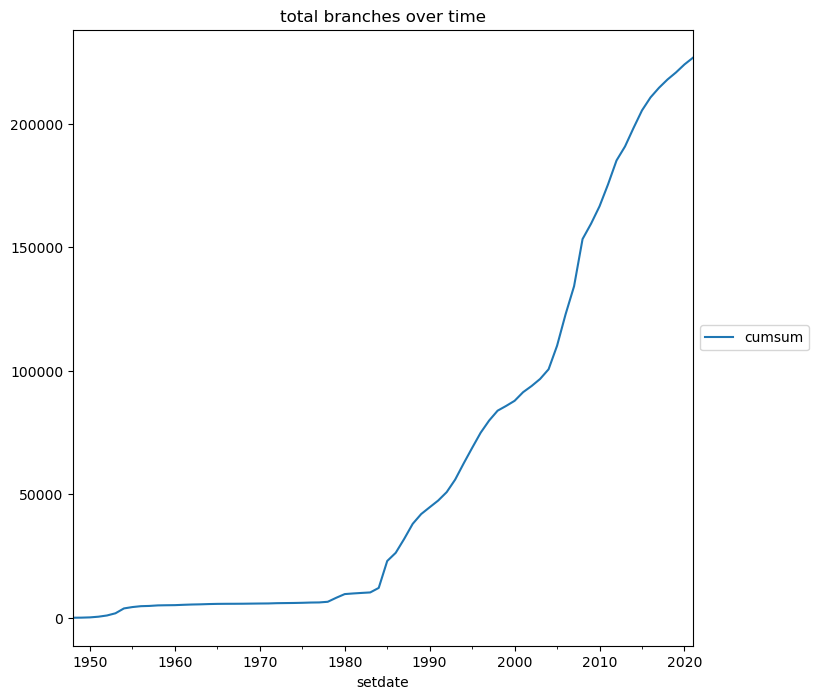

In [21]:
(
    df_bank
    .loc[lambda x: x['setdate'] < "2022"]
    .set_index(['setdate'])
    .groupby([pd.Grouper(freq='Y')])
    .agg({"id":"nunique"})
    .assign(cumsum = lambda x: x['id'].cumsum())
    .drop(columns = ['id'])
    .plot
    .line(title = 'total branches over time',figsize=(8,8))
    .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
plt.show()

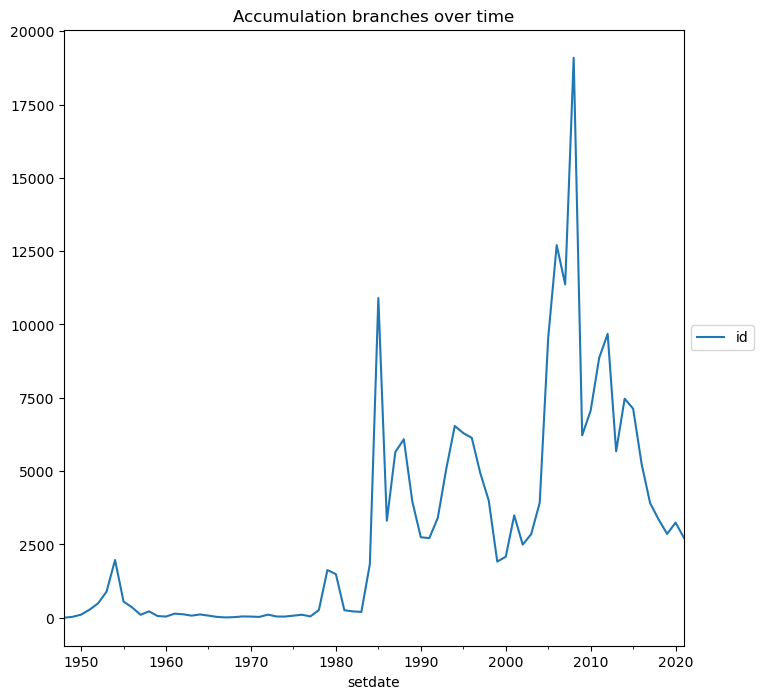

In [22]:
(
    df_bank
    .loc[lambda x: x['setdate'] < "2022"]
    .set_index(['setdate'])
    .groupby([pd.Grouper(freq='Y')])
    .agg({"id":"nunique"})
    #.assign(cumsum = lambda x: x['id'].cumsum())
    #.drop(columns = ['id'])
    .plot
    .line(title = 'Accumulation branches over time',figsize=(8,8))
    .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))   
)
plt.show()

list of banks in China

- Policy banks: China has three policy banks. Among them, China Development Bank was incorporated in December 2008 and officially defined by the State Council as a development finance institution in March 2015
    - 中国农业发展银行
    - 国家开发银行
    - 中国进出口银行
- State-owned Commercial Banks: China has six state-owned commercial banks. These banks are ranked by their Tier 1 capital amount as of 2018. 
    - 中国工商银行
    - 中国建设银行
    - 中国银行
    - 中国农业银行
    - 交通银行
    - 中国邮政储蓄银行
- Commercial Banks: China has 12 national commercial banks. These banks are ordered by their Tier 1 capital amount as of 2018
    - 招商银行
    - 上海浦东发展银行
    - 兴业银行
    - 中信银行
    - 中国民生银行
    - 中国光大银行
    - 平安银行
    - 华夏银行
    - 广发银行
    - 浙商银行
    - 渤海银行
    - 恒丰银行
    
Source: https://en.wikipedia.org/wiki/List_of_banks_in_China. More info in CSMAR data (where we got the data)df_bank_info

In [23]:
df_bank.shape

(227700, 51)

In [24]:
from polyfuzz import PolyFuzz
from polyfuzz.models import RapidFuzz
from polyfuzz.models import Embeddings
from flair.embeddings import TransformerWordEmbeddings
import seaborn as sns
sns.set_style("whitegrid",rc={'figure.figsize':(15,10)})

We already know the status of 75% of our dataset. The remaining banks are mostly city banks, so we well use fuzzy string matching to find them from the CSMAR dataset

In [25]:
df_bank['bank_type_adj'].dropna().shape[0]/df_bank.shape[0]

0.75010101010101

In [26]:
banks = (
    [ i.replace('（中国）','').strip() for i in 
     df_bank.loc[lambda x: x['bank_type_adj'].isin([np.nan])]['bank_full_name'].dropna().drop_duplicates().to_list()
     if len(i) > 1]
)
bank_info = df_bank_info['shortbnm'].to_list()
#bank_info_pinyin =  [pinyin.get(i, format="strip", delimiter=" ") for i in bank_info]
#model = PolyFuzz(rapidfuzz_matcher).match(banks, bank_info)
#model.get_matches()

In [27]:
banks[:5]

['郏县广天村镇银行股份', '长安银行股份', '甘肃银行股份', '安徽巢湖扬子村镇银行股份', '安徽肥东湖商村镇银行股份']

Let's make sure the city (or at least the location) is in the name; We can use this transformers https://huggingface.co/Davlan/xlm-roberta-base-wikiann-ner?text=%E6%9C%9D%E9%98%B3%E5%B8%82%E5%8F%8C%E5%A1%94%E5%8C%BA%E5%86%9C%E6%9D%91

In [28]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("Davlan/xlm-roberta-base-wikiann-ner")

model = AutoModelForTokenClassification.from_pretrained("Davlan/xlm-roberta-base-wikiann-ner")

In [29]:
def get_proba_city(x):
    ner = pipeline("ner", tokenizer=tokenizer,model=model,aggregation_strategy='simple')
    ner_results = ner(x)
    if len([i for i in ner_results if i['entity_group'] == 'LOC']) >0:
        dic = max(
            [i for i in ner_results if i['entity_group'] == 'LOC'],
            key=lambda x:x['score']
        )
        dic['name'] = x
        dic['applicable'] = True
    else:
        dic =  max(ner_results, key=lambda x:x['score'])
        dic['name'] = x
        dic['applicable'] = False
    return dic

In [30]:
from tqdm import tqdm

In [31]:
regex_loc = '|'.join(df_bank_info['cityname'].drop_duplicates().to_list()) + \
'|'+'|'.join(df_bank_info['provincename'].drop_duplicates().to_list()) + \
'|'+ '|'.join([i.replace('市',"").replace("省",'').replace('自治区',"")
 for i in df_bank_info['provincename'].drop_duplicates().to_list()]) + \
'|'+ '|'.join([i.replace('市',"").replace("省",'').replace('自治区',"")
 for i in df_bank_info['cityname'].drop_duplicates().to_list()])

In [32]:
true_loc = [i for i in banks if re.search(regex_loc,i)]

In [33]:
df_branch_to_check = pd.DataFrame([get_proba_city(i) for i in tqdm(banks) if i not in true_loc])

100%|##########| 3085/3085 [03:11<00:00, 16.15it/s]


In [34]:
df_branch_to_check.shape

(1937, 7)

In [35]:
(
    df_branch_to_check
    .groupby(['applicable'])
    .agg({'name':'unique'})
)

,name
applicable,
False,"[郏县广天村镇银行股份, 长安银行股份, 桂阳沪农商村镇银行股份, 中原银行股份, 哈密市商业银行股份, 汉口银行股份, 华夏银行股份, 平安银行股份, 昆仑银行股份, 新疆银行股份, 苍梧深通村镇银行, 海南银行股份, 涟源沪农商村镇银行股份, 凉城县乌拉特村镇银行, 南方电网财务, 振华集团财务, 中国长城资产管理股份, 中国华融资产管理股份, 双城惠民村镇银行, 五常惠民村镇银行, 睢县德商村镇银行股份, 安陆楚农商村镇银行股份, 长城国兴金融租赁, 长城新盛信托, 大悟楚农商村镇银行股份, 华融国际信托, 晋商银行股份, 庆云乐安村镇银行股份, 饶平融和村镇银行股份, 孝昌本富村镇银行, 新疆金风科技集团财务, 应城融兴村镇银行, 中国石化财务, 中国信达资产管理股份, 恒丰银行股份, 灵山泰业村镇银行股份, 湘乡市村镇银行股份, 中国民生银行股份, 中信银行股份, 东亚银行, 富滇银行股份, 盛京银行股份, 浙商银行股份, 中国光大银行股份, 汇丰银行, 东兴国民村镇银行, 来安中银富登村镇银行, 中国东方资产管理股份, 澳门国际银行股份, 徽商银行股份, 建水沪农商村镇银行股份, 创兴银行, 国民银行, 横琴华通金融租赁, 华能贵诚信托, 乐平融兴村镇银行, 蒙商银行股份, 南洋商业银行, 首都银行, 盂县汇民村镇银行, 巴彦融兴村镇银行, 长汀汀州红村镇银行股份, 固阳蒙商村镇银行股份, 浮梁农商村镇银行, 广发银行股份, 广西北部湾银行股份, 扶风浦发村镇银行股份, 广西鹿寨渝农商村镇银行, 霍林郭勒蒙银村镇银行股份, 招商银行股份, 黄平振兴村镇银行, 恩施兴福村镇银行股份, 韩亚银行, 花旗银行, 南宫市农村信用联社股份, 宁夏银行股份, 三井住友银行, 三亚惠民村镇银行股份, 友利银行, 澳大利亚和新西兰银行, 渤海银行股份, 第一商业银行股份, 齐商银行股份, 恒生银行, 摩根大通银行, 盘锦银行股份, 渣打银行, 张家口银行股份, 兴业银行股份, 莱商银行股份, 龙江银行股份, 中牟郑银村镇银行股份, 凤翔中银富登村镇银行, 华侨永亨银行, 韶山光大村镇银行股份, 林芝民生村镇银行股份, 确山郑银村镇银行股份, 上杭中成村镇银行股份, 尚志惠鑫村镇银行, 五矿国际信托, ...]"
True,"[民丰县农村, 青河县农村, 洛浦县农村, 文安县惠民村镇银行股份, 连城县农村, 灵山县农村, 德钦县农村, 科尔沁左翼后旗农村, 武川县农村, 夏邑县农村, 梨树县农村, 平乡县农村, 兴和县农村, 虞城县农村, 双江拉祜族佤族布朗族傣族自治县农村, 察哈尔右翼后旗农村信用联社股份, 金平苗族瑶族傣族自治县农村, 饶阳县农村信用联社股份, 依兰县农村, 建昌县农村, 广西象州, 金沙县农村, 隆尧县农村, 双辽市农村, 师宗县农村, 武邑县农村信用联社股份, 伊通满族自治县农村, 于田县农村, 广西柳江柳银村镇银行股份, 防城港市防城区农村, 佳木斯市农村, 洋县农村, 灵丘县长青村镇银行, 天镇县河东村镇银行, 武功县农村, 东乌珠穆沁旗农村, 淳化县农村, 水城县农村, 德宏芒市长江村镇银行股份, 和田市农村, 浑源县永安镇恒源鑫农村, 墨玉县农村, 南江县农村, 平昌县农村, 锡林浩特, 泽普县农村, 正镶白旗农村, 新河县农村, 皮山县农村, 丘北县农村, 香格里拉市农村, 东乌珠穆沁农信开元村镇银行, 英吉沙县农村, 通江县农村, 长汀县农村, 郧县楚农商村镇银行股份, 开阳县农村, 多伦县农村, 临洮县金城村镇银行股份, 马边彝族自治县农村, 苏尼特右旗农村, 朔州怀仁市慧融村镇银行股份, 朔州市朔城区蒙银村镇银行股份, 三亚市崖城镇众树农村, 吕梁市农村, 北海市区农村, 泰宁县农村, 渭源县农村, 正蓝旗农村, 阿合奇县农村, 沧源佤族自治县农村, 和田县农村, 西畴县农村, 阿克陶县农村, 沐川县农村, 扶风县农村, 巴楚县农村, 北票市农村, 二连浩特, 乌恰县农村, 合水县农村, 绥阳县农村, 正安县农村, 荥经县农村, 庆城县金城村镇银行股份, 疏附县农村, 镶黄旗农村, 肇东市农村, 江口县农村, 华池县农村, 山阴县太行村镇银行股份, 赤水市农村, 中阳县农村, 右玉县长青村镇银行, 调兵山市农村, 岑溪市北部湾村镇银行, 尼勒克县农村, 海伦市农村, 汉源县农村, 迁西县农村, ...]"


we can remove the branches which are not location, which mean we need to find 1774 differents banks

In [36]:
banks_to_find = sorted(true_loc + df_branch_to_check.loc[lambda x: x['applicable'].isin([True])]['name'].to_list())

In [37]:
banks_to_find[:10]

['万宁市和乐镇和港农村',
 '万荣县高村乡惠民农村',
 '三亚市崖城镇众树农村',
 '三原县农村',
 '上海上实集团财务',
 '上海东正汽车金融股份',
 '上海华瑞银行股份',
 '上海华谊集团财务',
 '上海商业储蓄银行股份',
 '上海商业银行']

In [38]:
to_find = False
if to_find:
    bert = TransformerWordEmbeddings('bert-base-multilingual-cased')
    bert_matcher = Embeddings(bert, min_similarity=0)
    models = PolyFuzz(bert_matcher).match(banks_to_find, bank_info)
    models.get_matches().to_csv('branch_matches.csv', index = False)

In [39]:
#bank_info

In [40]:
from polyfuzz.models import RapidFuzz
rapidfuzz_matcher = RapidFuzz(n_jobs=1)
model = PolyFuzz(rapidfuzz_matcher).match(banks_to_find, bank_info)

INFO: Ran model with model id = None

In [41]:
(
    model.get_matches()
    .sort_values(by = ['Similarity'])
    .loc[lambda x: x["Similarity"] > 0.85]
)

,From,To,Similarity
1570,重庆三峡银行股份,重庆三峡银行,0.857143
632,广东南粤银行股份,广东南粤银行,0.857143
631,广东华兴银行股份,广东华兴银行,0.857143
1280,珠海华润银行股份,珠海华润银行,0.857143
121,云南红塔银行股份,云南红塔银行,0.857143
...,...,...,...
894,永城齐鲁村镇银行,永城齐鲁村镇银行,1.000000
1544,邯郸永年齐鲁村镇银行,邯郸永年齐鲁村镇银行,1.000000
1606,重庆渝北银座村镇银行,重庆渝北银座村镇银行,1.000000
1303,登封齐鲁村镇银行,登封齐鲁村镇银行,1.000000


In [42]:
df_bank_branches = (
    pd.read_csv(
        "branch_matches.csv",
        dtype={
            "id": "str",
            "geocode4_corr": "str",
            "lostReason": "str",
            "location": "str",
            "city_temp": "str",
            "points": "str",
        },
    )
    .sort_values(by=["Similarity"])
    .loc[lambda x: x["Similarity"] > 0.85]
    .merge(
        df_bank_info.reindex(columns=["bnm_cn", "shortbnm", "bnature"]).rename(
            columns={"shortbnm": "To"}
        )
    )
    .replace(
        {
            "bnature": {
                "政策性银行": "policy bank",
                "国有控股大型商业银行": "sob",
                "股份制商业银行": "joint-stock commercial bank",
                "城市商业银行": "city commercial bank",
                "农村商业银行": "rural commercial bank",
                "外资银行": "foreign bank",
                "其他": "other",
                "农合行": "other",
                "农信社": "other",
                "三类新型农村金融机构": "other",
            }
        }
    )
    .rename(columns={"bnature": "bank_type_adj"})
    .merge(
        (
            df_bank.drop_duplicates(subset=["bank_full_name"])
            .reindex(
                columns=[
                    "id",
                    "setdate",
                    "year_setdate",
                    "fullname",
                    "bank_full_name",
                    "registration_type",
                    "city",
                    "geocode4_corr",
                    "bank_type",
                    # "bank_type_adj",
                ]
            )
            .assign(
                bank_full_name_=lambda x: x["bank_full_name"]
                .replace("（中国）", "")
                .str.strip()
            )
            .rename(columns={"bank_full_name_": "From"})
        )
    )
    .reindex(
        columns=[
            "id",
            "setdate",
            "year_setdate",
            "fullname",
            "bank_full_name",
            "registration_type",
            "city",
            "geocode4_corr",
            "bank_type",
            "bank_type_adj",
        ]
    )
)

df_bank_branches = pd.concat(
    [
        (
            df_bank.loc[
                lambda x: ~x["id"].isin(df_bank_branches["id"].to_list())
            ].reindex(
                columns=[
                    "id",
                    "setdate",
                    "year_setdate",
                    "fullname",
                    "bank_full_name",
                    "registration_type",
                    "city",
                    "geocode4_corr",
                    "bank_type",
                    "bank_type_adj",
                ]
            )
        ),
        df_bank_branches,
    ]
).assign(
    bank_type_adj_clean=lambda x: x.groupby(["bank_full_name"])[
        "bank_type_adj"
    ].transform(lambda x: x.ffill().bfill())
)

In [43]:
(
    df_bank_branches
    .loc[lambda x: x["bank_type_adj_clean"].isin(['city commercial bank'])]
    ['bank_full_name']
    .value_counts()
    .reset_index()
    .sort_values(by = ['index'])
)

,index,bank_full_name
6,上海银行股份,337
28,东莞银行股份,171
43,东营银行股份,119
49,丹东银行股份,106
82,乌海银行股份,46
...,...,...
5,长沙银行股份,359
60,阜新银行股份,84
94,雅安市商业银行股份,28
59,青海银行股份,85


In [44]:
df_bank_branches.head()

,id,setdate,year_setdate,fullname,bank_full_name,registration_type,city,geocode4_corr,bank_type,bank_type_adj,bank_type_adj_clean
0,115856,2008-07-31,2008,中国邮政储蓄银行股份有限公司玉山县仙岩镇营业所,中国邮政储蓄银行股份,有限公司,NaN,<NA>,中国邮政储蓄银行,SOB,SOB
1,115815,1995-12-18,1995,中国邮政储蓄银行股份有限公司玉山县岩瑞镇古城营业所,中国邮政储蓄银行股份,有限公司,NaN,<NA>,中国邮政储蓄银行,SOB,SOB
2,115775,1995-12-18,1995,中国邮政储蓄银行股份有限公司玉山县岩瑞镇营业所,中国邮政储蓄银行股份,有限公司,NaN,<NA>,中国邮政储蓄银行,SOB,SOB
3,137210,2009-10-23,2009,郏县广天村镇银行股份有限公司,郏县广天村镇银行股份,有限公司,平顶山,4104,NaN,NaN,NaN
4,137208,2019-07-15,2019,郏县广天村镇银行股份有限公司安良镇支行,郏县广天村镇银行股份,有限公司,NaN,<NA>,NaN,NaN,NaN


Example of banks without confident bank type

In [45]:
(
    pd.read_csv(
        "branch_matches.csv",
        dtype={
            "id": "str",
            "geocode4_corr": "str",
            "lostReason": "str",
            "location": "str",
            "city_temp": "str",
            "points": "str",
        },
    )
    .sort_values(by=["From"])
    .loc[lambda x: x["Similarity"] <= 0.85]
)

,From,To,Similarity
0,万宁市和乐镇和港农村,万载农商银行,0.629
1,万荣县高村乡惠民农村,万载农商银行,0.589
2,三亚市崖城镇众树农村,三门峡市商业银行,0.728
3,三原县农村,三明农商银行,0.803
5,上海东正汽车金融股份,上海农商银行,0.848
...,...,...,...
1769,黑龙江省农村,龙江银行,0.527
1770,黑龙江肇东中银富登村镇银行,龙江银行,0.526
1771,齐齐哈尔市农村,齐鲁银行,0.688
1772,龙岩市永定区农村,龙岩农商银行,0.830


Compute Herfhindal index:

$$
H H I_{c, t}=\sum_{k=1}^{N}\left(\frac{\text { Number of } \text { Branches }_{k t}}{\sum_{k=1}^{N} \text { Number of } \text { Branches }_{k t }}\right)^{2} .
$$

represents the HHI of the local banking market in city $c$ and
is calculated on the basis of the number of bank branches of all banks k locally present for each year (with
N the total number of banks in the country).

We need to make a panel for each bank because the data only shows when a new branch is added, but in the case where there is no new branch, the bank has still a market share.

See example below, the bank "上海银行股份" is in business since 2009, and created 2 other branches in 2011. In 2010, the bank was still opearting the branch, so we need to create this new row

The bank regulation index:

$$
\operatorname{Bank}_{\mathrm{HHI}_{c, t}}=1-\mathrm{HHI}_{c, t}
$$

It ranges from zero to one with zero indicating the most stringent regulation and one indicating the most deregulation.

download exiting branches

In [46]:
import warnings
import boto3
import io
warnings.filterwarnings("ignore")
client_ = boto3.resource('s3')
PATH_S3= "DATA/ECON/CHINA/CHINA_BANKING_AND_INSURANCE_REGULATORY_COMMISSION/BANK_BRANCHES"
list_s3 = s3.list_all_files_with_prefix(prefix=os.path.join(PATH_S3, 'RAW_JSON_EXIT'))
def convert_to_df(key):
    obj = client_.Object(bucket, key)
    body = obj.get()['Body'].read()
    fix_bytes_value = body.replace(b"'", b'"')
    my_json = json.load(io.BytesIO(fix_bytes_value))
    return pd.DataFrame(my_json)

df_exit = pd.concat(map(convert_to_df, list_s3))

INFO: Found credentials in shared credentials file: %s

In [47]:
temp = (
    df_bank_branches
    .loc[lambda x: ~x["bank_type_adj_clean"].isin([#"SOB",
        "rural commercial bank",
        'policy bank', 'other',
        'joint-stock commercial bank','foreign bank'])]
    .loc[lambda x: x['setdate'] < "2013"]
    .loc[lambda x: ~x['geocode4_corr'].isin(["<NA>"])]
    .dropna(subset = ['bank_type_adj_clean'])
    .groupby(['year_setdate', 'geocode4_corr', 'bank_full_name'])
    .agg({'id':'count'})
    .sort_values(by = ["bank_full_name","geocode4_corr", "year_setdate"])
    .loc[lambda x: x.index.get_level_values('bank_full_name').isin(['上海银行股份'])]
    #.loc[lambda x: x.index.get_level_values('geocode4_corr').isin(['1101'])]
    .reset_index()
)
temp.head()

,year_setdate,geocode4_corr,bank_full_name,id
0,2009,1101,上海银行股份,1
1,2011,1101,上海银行股份,2
2,2008,1201,上海银行股份,1
3,2009,1201,上海银行股份,1
4,2010,1201,上海银行股份,1


Concentration ratio

$$
\mathrm{CR}_{\text {bigfour }_{c, t}}=\left(\operatorname{Branch}_{c, t}^{\mathrm{BOC}}+\operatorname{Branch}_{c, t}^{\mathrm{ICBC}}+\operatorname{Branch}_{c, t}^{\mathrm{CCB}}+\operatorname{Branch}_{c, t}^{\mathrm{ABC}}\right) / \text { TotalBranch }_{c, t}
$$

with

Bank of China (BOC), Agricultural Bank of China (ABC), China Construction Bank (CCB) and Industrial and Commercial Bank of China (ICBC).

In [48]:
def big_four(x):
    if x == "中国农业银行股份":
        return "中国农业银行股份"
    elif x == "中国工商银行股份":
        return "中国工商银行股份"
    elif x == "中国建设银行股份":
        return "中国建设银行股份"
    elif x == "中国银行股份":
        return "中国银行股份"
    else:
        return 'other'

Add the data to the pollution dataset

In [49]:
(
    df_exit
    .assign(
    year_setdate = lambda x: pd.to_datetime(x['date']).dt.year
    )
    ['year_setdate'].value_counts()
    .reset_index()
    .sort_values(by = ['index'])
)

,index,year_setdate
7,2007,2112
0,2008,4585
4,2009,2895
9,2010,1049
12,2011,622
15,2012,423
14,2013,604
13,2014,616
10,2015,805
8,2016,1496


In [50]:
df_deregulation = (
    (
        df_bank_branches
        # .loc[lambda x: ~x["geocode4_corr"].isin(["<NA>"])]
        .merge(df_bank.reindex(columns=["id", "certcode"]))
        .assign(
            bank_full_name=lambda x: x["certcode"].astype(str).str.slice(stop=5),
            city_id=lambda x: x["certcode"].astype(str).str.slice(start=7, stop=11),
            is_equal=lambda x: x["city_id"] == x["geocode4_corr"],
            geocode4_corr=lambda x: np.where(
                x["is_equal"], x["geocode4_corr"], x["city_id"]
            ),
            types=lambda x: x["certcode"].astype(str).str.slice(start=5, stop=6),
        )
        .loc[lambda x: x["types"].isin(["S"])]
        .assign(
            bank_type_adj_clean=lambda x: x["bank_type_adj_clean"].fillna(
                "city commercial bank"
            )
        )
        # .dropna(subset=["bank_type_adj_clean", "bank_type_adj"])
        .pivot_table(
            values="id",
            index=["bank_type_adj_clean", "geocode4_corr"],
            columns="year_setdate",
            aggfunc=len,
            fill_value=0,
        )
        .stack()
        .reset_index()
        .rename(columns={0: "count"})
        .assign(
            count=lambda x: x.groupby(["bank_type_adj_clean", "geocode4_corr"])[
                "count"
            ].transform("cumsum")
        )
        .set_index(["bank_type_adj_clean", "geocode4_corr", "year_setdate"])
        .unstack(0)
        .fillna(0)
        .droplevel(axis=1, level=0)
        .reset_index()
        .loc[lambda x: ~x["year_setdate"].isin(["<NA>"])]
    )
    .merge(
        (
            df_bank_branches
            # .loc[lambda x: ~x["geocode4_corr"].isin(["<NA>"])]
            .merge(df_bank.reindex(columns=["id", "certcode"]))
            .assign(
                bank_full_name=lambda x: x["certcode"].astype(str).str.slice(stop=5),
                city_id=lambda x: x["certcode"].astype(str).str.slice(start=7, stop=11),
                is_equal=lambda x: x["city_id"] == x["geocode4_corr"],
                geocode4_corr=lambda x: np.where(
                    x["is_equal"], x["geocode4_corr"], x["city_id"]
                ),
                types=lambda x: x["certcode"].astype(str).str.slice(start=5, stop=6),
            )
            .loc[lambda x: x["types"].isin(["S"])]
            .loc[lambda x: ~x["year_setdate"].isin(["<NA>"])]
            # .loc[
            #    lambda x: ~x["bank_type_adj_clean"].isin(
            #        [
            #             # "SOB",
            #             "rural commercial bank",
            #             "policy bank",
            #            "other",
            #            "joint-stock commercial bank",
            #            "foreign bank",
            #        ]
            #    )
            # ]
            .dropna(
                subset=[
                    "bank_type_adj_clean",
                    # "bank_type_adj"
                ]
            )
            .groupby(["year_setdate", "geocode4_corr", "bank_full_name"])
            .agg({"id": "count"})
            .sort_values(by=["bank_full_name", "geocode4_corr", "year_setdate"])
            .reset_index()
            .pivot_table(
                values="id",
                index=["bank_full_name", "geocode4_corr"],
                columns="year_setdate",
                aggfunc=np.sum,
                # fill_value=0,
            )
            .stack(dropna=False)
            .reset_index()
            .rename(columns={0: "count"})
            .assign(
                temp=lambda x: x.groupby(["bank_full_name", "geocode4_corr"])[
                    "count"
                ].transform("cumsum"),
                temp_1=lambda x: x.groupby(["bank_full_name", "geocode4_corr", "temp"])[
                    "year_setdate"
                ]
                .transform("min")
                .fillna("2222")
                .astype("int"),
                first_entry=lambda x: x.groupby(["bank_full_name", "geocode4_corr"])[
                    "temp_1"
                ].transform("min"),
                count=lambda x: x["count"].fillna(0),
            )
            .loc[lambda x: x["year_setdate"].astype("int") >= x["first_entry"]]
            .drop(columns=["temp", "temp_1", "first_entry"])
            .assign(
                totalBranchBank=lambda x: x.groupby(
                    ["bank_full_name", "geocode4_corr"]
                )["count"].transform("cumsum"),
                totalBranchCity=lambda x: x.groupby(["geocode4_corr", "year_setdate"])[
                    "totalBranchBank"
                ].transform("sum"),
                deregulation=lambda x: (x["totalBranchBank"] / x["totalBranchCity"])
                ** 2,
            )
            .groupby(["year_setdate", "geocode4_corr"])
            .agg({"deregulation": "sum"})
            .reset_index()
            .dropna(subset=["deregulation"])
            .assign(deregulation_ct=lambda x: x["deregulation"]#1 - x["deregulation"]
                   )
        ),
        how="left",
        on=["year_setdate", "geocode4_corr"],
    )
    .merge(
        (
            df_bank_branches.assign(
                sob=lambda x: x.apply(lambda x: big_four(x["bank_full_name"]), axis=1)
            )
            .loc[lambda x: ~x["geocode4_corr"].isin(["<NA>"])]
            .dropna(subset=["bank_type_adj_clean", "bank_type_adj"])
            .groupby(["year_setdate", "geocode4_corr", "sob"])
            .agg({"id": "count"})
            .sort_values(by=["sob", "geocode4_corr", "year_setdate"])
            .reset_index()
            .pivot_table(
                values="id",
                index=["sob", "geocode4_corr"],
                columns="year_setdate",
                aggfunc=np.sum,
                fill_value=0,
            )
            .stack()
            .reset_index()
            .rename(columns={0: "count"})
            .assign(
                temp=lambda x: x.groupby(["sob", "geocode4_corr"])[
                    "count"
                ].transform("cumsum"),
                temp_1=lambda x: x.groupby(["sob", "geocode4_corr", "temp"])[
                    "year_setdate"
                ]
                .transform("min")
                .fillna("2222")
                .astype("int"),
                first_entry=lambda x: x.groupby(["sob", "geocode4_corr"])[
                    "temp_1"
                ].transform("min"),
                count=lambda x: x["count"].fillna(0),
            )
            .loc[lambda x: x["year_setdate"].astype("int") >= x["first_entry"]]
            .drop(columns=["temp", "temp_1", "first_entry"])
            .assign(
                totalBranchBank=lambda x: x.groupby(["sob", "geocode4_corr"])[
                    "count"
                ].transform("cumsum"),
                totalBranchCity=lambda x: x.groupby(["geocode4_corr", "year_setdate"])[
                    "totalBranchBank"
                ].transform("sum"),
                #    score = lambda x: (x['totalBranchBank']/x['totalBranchCity'])**2
            )
            .loc[lambda x: x["sob"] != "other"]
            .set_index(["sob", "geocode4_corr", "year_setdate", "totalBranchCity"])
            .drop(columns=["count"])
            .unstack(0)
            .assign(total_sob=lambda x: x.sum(axis=1))
            .reset_index(["totalBranchCity"])
            .assign(
                concentration_sob=lambda x: x[("total_sob", "")]
                / x[("totalBranchCity", "")]
            )
            .reindex(columns=[("total_sob", ""), ("concentration_sob", "")])
            .droplevel(axis=1, level=1)
            .reset_index()
            .dropna(subset=["concentration_sob"])
            .assign(concentration_sob_ct=lambda x: 1 - x["concentration_sob"]
                   )
        ),
        how="left",
        on=["year_setdate", "geocode4_corr"],
    )
    .merge(
        (
            df_bank_branches
            # .loc[lambda x: ~x["geocode4_corr"].isin(["<NA>"])]
            .merge(df_bank.reindex(columns=["id", "certcode"]))
            .assign(
                bank_full_name=lambda x: x["certcode"].astype(str).str.slice(stop=5),
                city_id=lambda x: x["certcode"].astype(str).str.slice(start=7, stop=11),
                is_equal=lambda x: x["city_id"] == x["geocode4_corr"],
                geocode4_corr=lambda x: np.where(
                    x["is_equal"], x["geocode4_corr"], x["city_id"]
                ),
                types=lambda x: x["certcode"].astype(str).str.slice(start=5, stop=6),
            )
            .loc[lambda x: x["types"].isin(["S"])]
            .loc[lambda x: ~x["year_setdate"].isin(["<NA>"])]
            .assign(
                bank_type_adj_clean=lambda x: x["bank_type_adj_clean"].fillna(
                    "city commercial bank"
                )
            )
            # .loc[
            #    lambda x: ~x["bank_type_adj_clean"].isin(
            #        [
            #            # "SOB",
            #             "rural commercial bank",
            #             "policy bank",
            #            "other",
            #            "joint-stock commercial bank",
            #            "foreign bank",
            #        ]
            #    )
            # ]
            .dropna(
                subset=[
                    "bank_type_adj_clean",
                    # "bank_type_adj"
                ]
            )
            .groupby(
                [
                    "year_setdate",
                    "geocode4_corr",
                    "bank_type_adj_clean",
                    "bank_full_name",
                ]
            )
            .agg({"id": "count"})
            .sort_values(by=["bank_full_name", "geocode4_corr", "year_setdate"])
            .reset_index()
            .pivot_table(
                values="id",
                index=["bank_full_name", "bank_type_adj_clean", "geocode4_corr"],
                columns="year_setdate",
                aggfunc=np.sum,
                # fill_value=0,
            )
            .stack(dropna=False)
            .reset_index()
            .rename(columns={0: "count"})
            .assign(
                temp=lambda x: x.groupby(["bank_full_name", "geocode4_corr"])[
                    "count"
                ].transform("cumsum"),
                temp_1=lambda x: x.groupby(["bank_full_name", "geocode4_corr", "temp"])[
                    "year_setdate"
                ]
                .transform("min")
                .fillna("2222")
                .astype("int"),
                first_entry=lambda x: x.groupby(["bank_full_name", "geocode4_corr"])[
                    "temp_1"
                ].transform("min"),
                count=lambda x: x["count"].fillna(0),
            )
            .loc[lambda x: x["year_setdate"].astype("int") >= x["first_entry"]]
            .drop(columns=["temp", "temp_1", "first_entry"])
            .assign(
                totalBranchBank=lambda x: x.groupby(
                    ["bank_full_name", "geocode4_corr"]
                )["count"].transform("cumsum"),
                totalBranchCity=lambda x: x.groupby(["geocode4_corr", "year_setdate"])[
                    "totalBranchBank"
                ].transform("sum"),
                deregulation=lambda x: (x["totalBranchBank"] / x["totalBranchCity"])
                ** 2,
            )
            .loc[lambda x: x["bank_type_adj_clean"].isin(["city commercial bank"])]
            .groupby(["year_setdate", "geocode4_corr"])
            .agg({"totalBranchBank": "sum", "totalBranchCity": "mean"})
            .assign(share_branch=lambda x: x["totalBranchBank"] / x["totalBranchCity"])
            .reset_index()
        ),
        how="left",
        on=["year_setdate", "geocode4_corr"],
    )
    .rename(
        columns={
            "city commercial bank": "city_commercial_bank",
            "foreign bank": "foreign_bank",
            "joint-stock commercial bank": "joint_stock_commercial_bank",
            "policy bank": "policy_bank",
            "rural commercial bank": "rural_commercial_bank",
        }
    )
    .assign(
        share_commercial_branch=lambda x: x["city_commercial_bank"]
        / x["totalBranchCity"],
        share_branch=lambda x: x["share_branch"].fillna(0),
    )
    .assign(share_commercial_branch=lambda x: x["share_commercial_branch"].fillna(0))
)
df_deregulation = df_deregulation.assign(
    **{
        "lag_{}".format(i): df_deregulation.groupby(["geocode4_corr"])[i].transform(
            "shift"
        )
        for i in [
            "city_commercial_bank",
            "share_commercial_branch",
            "totalBranchBank",
            "totalBranchCity",
            "deregulation_ct",
            #'deregulation',
            "concentration_sob_ct",
            "share_branch",
        ]
    }
)
df_deregulation.loc[lambda x: x["year_setdate"] > "1995"][
    [
        "lag_city_commercial_bank",
        "lag_totalBranchBank",
        "lag_totalBranchCity",
        "lag_share_commercial_branch",
        "deregulation_ct",
        "lag_deregulation_ct",
        "concentration_sob_ct",
        "lag_concentration_sob_ct",
        "share_branch",
        "lag_share_branch",
    ]
].describe(percentiles=np.arange(0, 1, 0.1))

,lag_city_commercial_bank,lag_totalBranchBank,lag_totalBranchCity,lag_share_commercial_branch,deregulation_ct,lag_deregulation_ct,concentration_sob_ct,lag_concentration_sob_ct,share_branch,lag_share_branch
count,9450.000000,6766.000000,6766.000000,9450.000000,9422.000000,9420.000000,7614.000000,7614.000000,9450.000000,9450.000000
mean,38.005291,53.081584,338.240024,0.092952,0.189749,0.195193,0.508477,0.497844,0.099192,0.092952
std,82.415811,93.203173,348.887466,0.109033,0.133060,0.134978,0.188795,0.193487,0.111522,0.109033
min,0.000000,1.000000,1.000000,0.000000,0.047931,0.047931,0.000000,0.000000,0.000000,0.000000
0%,0.000000,1.000000,1.000000,0.000000,0.047931,0.047931,0.000000,0.000000,0.000000,0.000000
10%,0.000000,2.000000,80.000000,0.000000,0.086773,0.088606,0.240421,0.217391,0.000000,0.000000
20%,0.000000,5.000000,117.000000,0.000000,0.102538,0.104990,0.325069,0.308271,0.000000,0.000000
30%,1.000000,10.000000,155.000000,0.007407,0.118291,0.121314,0.410105,0.394708,0.013889,0.007407
40%,4.000000,17.000000,191.000000,0.029630,0.135919,0.140482,0.486881,0.470085,0.038961,0.029630
50%,10.000000,23.000000,239.000000,0.059115,0.157053,0.162525,0.552559,0.540230,0.069800,0.059115


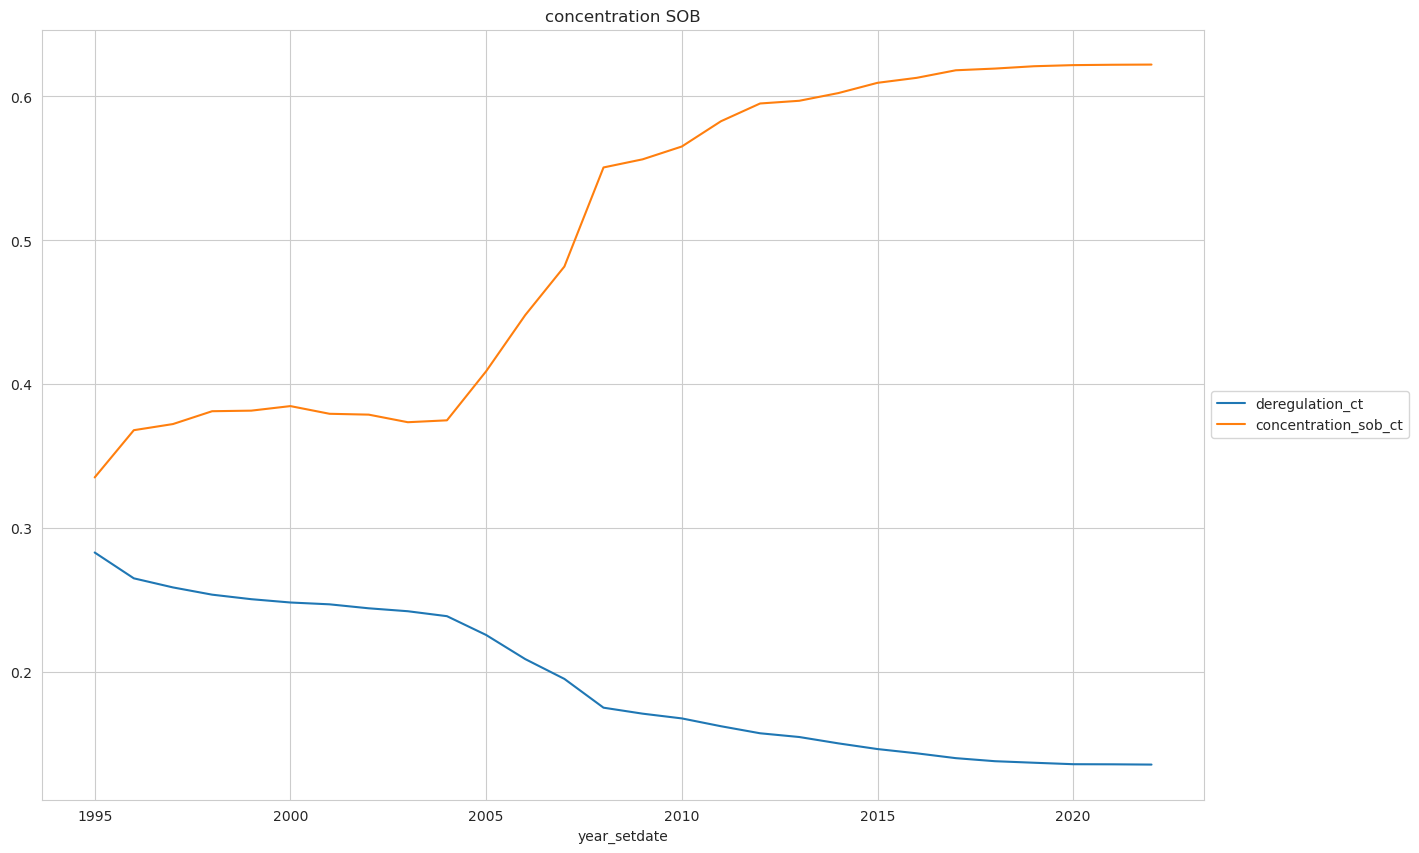

In [51]:
(
    df_deregulation
    .loc[lambda x: x['year_setdate'] > "1994"]
    .groupby("year_setdate")
    .agg({
        "deregulation_ct": "mean",
        "concentration_sob_ct":"mean",
        #'share_branch':'mean'
    })
    .plot.line(title="concentration SOB", figsize=(15, 10))
    .legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
)
plt.show()

In [52]:
(
    df_deregulation
    .loc[lambda x: x['geocode4_corr'].isin(['6110'])]
    .loc[lambda x: x['year_setdate'] > "2000"]
)

,geocode4_corr,year_setdate,SOB,city_commercial_bank,foreign_bank,other,policy_bank,rural_commercial_bank,deregulation,deregulation_ct,total_sob,concentration_sob,concentration_sob_ct,totalBranchBank,totalBranchCity,share_branch,share_commercial_branch,lag_city_commercial_bank,lag_share_commercial_branch,lag_totalBranchBank,lag_totalBranchCity,lag_deregulation_ct,lag_concentration_sob_ct,lag_share_branch
23003,6110,2001,37.0,0.0,0.0,0.0,6.0,1.0,0.283058,0.283058,35.0,0.795455,0.204545,NaN,NaN,0.000000,0.000000,0.0,0.000000,NaN,NaN,0.283058,0.204545,0.000000
23004,6110,2002,37.0,0.0,0.0,0.0,6.0,1.0,0.283058,0.283058,35.0,0.795455,0.204545,NaN,NaN,0.000000,0.000000,0.0,0.000000,NaN,NaN,0.283058,0.204545,0.000000
23005,6110,2003,37.0,0.0,0.0,0.0,6.0,1.0,0.283058,0.283058,35.0,0.795455,0.204545,NaN,NaN,0.000000,0.000000,0.0,0.000000,NaN,NaN,0.283058,0.204545,0.000000
23006,6110,2004,37.0,0.0,0.0,0.0,6.0,1.0,0.283058,0.283058,35.0,0.795455,0.204545,NaN,NaN,0.000000,0.000000,0.0,0.000000,NaN,NaN,0.283058,0.204545,0.000000
23007,6110,2005,37.0,2.0,0.0,0.0,6.0,40.0,0.198142,0.198142,35.0,0.546875,0.453125,2.0,85.0,0.023529,0.023529,0.0,0.000000,NaN,NaN,0.283058,0.204545,0.000000
23008,6110,2006,38.0,2.0,0.0,0.0,6.0,40.0,0.198980,0.198980,37.0,0.560606,0.439394,2.0,86.0,0.023256,0.023256,2.0,0.023529,2.0,85.0,0.198142,0.453125,0.023529
23009,6110,2007,38.0,2.0,0.0,0.0,6.0,40.0,0.198980,0.198980,37.0,0.560606,0.439394,2.0,86.0,0.023256,0.023256,2.0,0.023256,2.0,86.0,0.198980,0.439394,0.023256
23010,6110,2008,38.0,2.0,0.0,0.0,6.0,40.0,0.198980,0.198980,37.0,0.560606,0.439394,2.0,86.0,0.023256,0.023256,2.0,0.023256,2.0,86.0,0.198980,0.439394,0.023256
23011,6110,2009,38.0,2.0,0.0,0.0,6.0,40.0,0.198980,0.198980,37.0,0.560606,0.439394,2.0,86.0,0.023256,0.023256,2.0,0.023256,2.0,86.0,0.198980,0.439394,0.023256
23012,6110,2010,39.0,2.0,0.0,0.0,6.0,41.0,0.196863,0.196863,38.0,0.550725,0.449275,2.0,88.0,0.022727,0.022727,2.0,0.023256,2.0,86.0,0.198980,0.439394,0.023256


deregulation province

In [53]:
df_deregulation_p = (
    (
        df_bank_branches
        # .loc[lambda x: ~x["geocode4_corr"].isin(["<NA>"])]
        .merge(df_bank.reindex(columns=["id", "certcode"]))
        .assign(
            bank_full_name=lambda x: x["certcode"].astype(str).str.slice(stop=5),
            city_id=lambda x: x["certcode"].astype(str).str.slice(start=7, stop=11),
            is_equal=lambda x: x["city_id"] == x["geocode4_corr"],
            geocode4_corr=lambda x: np.where(
                x["is_equal"], x["geocode4_corr"], x["city_id"]
            ),
            types=lambda x: x["certcode"].astype(str).str.slice(start=5, stop=6),
        )
        .loc[lambda x: x["types"].isin(["S"])]
        .merge(
            (
                df.assign(geocode4_corr=lambda x: x["geocode4_corr"].astype("str"))
                .reindex(columns=["geocode4_corr", "province_en"])
                .drop_duplicates(subset=["geocode4_corr"])
            )
        )
        .assign(
            bank_type_adj_clean=lambda x: x["bank_type_adj_clean"].fillna(
                "city commercial bank"
            )
        )
        # .dropna(subset=["bank_type_adj_clean", "bank_type_adj"])
        .pivot_table(
            values="id",
            index=["bank_type_adj_clean", "province_en"],
            columns="year_setdate",
            aggfunc=len,
            fill_value=0,
        )
        .stack()
        .reset_index()
        .rename(columns={0: "count"})
        .assign(
            count=lambda x: x.groupby(["bank_type_adj_clean", "province_en"])[
                "count"
            ].transform("cumsum")
        )
        .set_index(["bank_type_adj_clean", "province_en", "year_setdate"])
        .unstack(0)
        .fillna(0)
        .droplevel(axis=1, level=0)
        .reset_index()
        .loc[lambda x: ~x["year_setdate"].isin(["<NA>"])]
    )
    .merge(
        (
            df_bank_branches
            # .loc[lambda x: ~x["geocode4_corr"].isin(["<NA>"])]
            .merge(df_bank.reindex(columns=["id", "certcode"]))
            .assign(
                bank_full_name=lambda x: x["certcode"].astype(str).str.slice(stop=5),
                city_id=lambda x: x["certcode"].astype(str).str.slice(start=7, stop=11),
                is_equal=lambda x: x["city_id"] == x["geocode4_corr"],
                geocode4_corr=lambda x: np.where(
                    x["is_equal"], x["geocode4_corr"], x["city_id"]
                ),
                types=lambda x: x["certcode"].astype(str).str.slice(start=5, stop=6),
            )
            .loc[lambda x: x["types"].isin(["S"])]
            .loc[lambda x: ~x["year_setdate"].isin(["<NA>"])]
            .merge(
            (
                df.assign(geocode4_corr=lambda x: x["geocode4_corr"].astype("str"))
                .reindex(columns=["geocode4_corr", "province_en"])
                .drop_duplicates(subset=["geocode4_corr"])
            )
        )
            # .loc[
            #    lambda x: ~x["bank_type_adj_clean"].isin(
            #        [
            #             # "SOB",
            #             "rural commercial bank",
            #             "policy bank",
            #            "other",
            #            "joint-stock commercial bank",
            #            "foreign bank",
            #        ]
            #    )
            # ]
            .dropna(
                subset=[
                    "bank_type_adj_clean",
                    # "bank_type_adj"
                ]
            )
            .groupby(["year_setdate", "province_en", "bank_full_name"])
            .agg({"id": "count"})
            .sort_values(by=["bank_full_name", "province_en", "year_setdate"])
            .reset_index()
            .pivot_table(
                values="id",
                index=["bank_full_name", "province_en"],
                columns="year_setdate",
                aggfunc=np.sum,
                # fill_value=0,
            )
            .stack(dropna=False)
            .reset_index()
            .rename(columns={0: "count"})
            .assign(
                temp=lambda x: x.groupby(["bank_full_name", "province_en"])[
                    "count"
                ].transform("cumsum"),
                temp_1=lambda x: x.groupby(["bank_full_name", "province_en", "temp"])[
                    "year_setdate"
                ]
                .transform("min")
                .fillna("2222")
                .astype("int"),
                first_entry=lambda x: x.groupby(["bank_full_name", "province_en"])[
                    "temp_1"
                ].transform("min"),
                count=lambda x: x["count"].fillna(0),
            )
            .loc[lambda x: x["year_setdate"].astype("int") >= x["first_entry"]]
            .drop(columns=["temp", "temp_1", "first_entry"])
            .assign(
                totalBranchBank=lambda x: x.groupby(
                    ["bank_full_name", "province_en"]
                )["count"].transform("cumsum"),
                totalBranchCity=lambda x: x.groupby(["province_en", "year_setdate"])[
                    "totalBranchBank"
                ].transform("sum"),
                deregulation=lambda x: (x["totalBranchBank"] / x["totalBranchCity"])
                ** 2,
            )
            .groupby(["year_setdate", "province_en"])
            .agg({"deregulation": "sum"})
            .reset_index()
            .dropna(subset=["deregulation"])
            .assign(deregulation_ct=lambda x: 1 - x["deregulation"])
        ),
        how="left",
        on=["year_setdate", "province_en"],
    )
    .merge(
        (
            df_bank_branches.assign(
                sob=lambda x: x.apply(lambda x: big_four(x["bank_full_name"]), axis=1)
            )
            .loc[lambda x: ~x["geocode4_corr"].isin(["<NA>"])]
            .merge(
            (
                df.assign(geocode4_corr=lambda x: x["geocode4_corr"].astype("str"))
                .reindex(columns=["geocode4_corr", "province_en"])
                .drop_duplicates(subset=["geocode4_corr"])
            )
        )
            .dropna(subset=["bank_type_adj_clean", "bank_type_adj"])
            .groupby(["year_setdate", "province_en", "sob"])
            .agg({"id": "count"})
            .sort_values(by=["sob", "province_en", "year_setdate"])
            .reset_index()
            .pivot_table(
                values="id",
                index=["sob", "province_en"],
                columns="year_setdate",
                aggfunc=np.sum,
                fill_value=0,
            )
            .stack()
            .reset_index()
            .rename(columns={0: "count"})
            .assign(
                temp=lambda x: x.groupby(["sob", "province_en"])[
                    "count"
                ].transform("cumsum"),
                temp_1=lambda x: x.groupby(["sob", "province_en", "temp"])[
                    "year_setdate"
                ]
                .transform("min")
                .fillna("2222")
                .astype("int"),
                first_entry=lambda x: x.groupby(["sob", "province_en"])[
                    "temp_1"
                ].transform("min"),
                count=lambda x: x["count"].fillna(0),
            )
            .loc[lambda x: x["year_setdate"].astype("int") >= x["first_entry"]]
            .drop(columns=["temp", "temp_1", "first_entry"])
            .assign(
                totalBranchBank=lambda x: x.groupby(["sob", "province_en"])[
                    "count"
                ].transform("cumsum"),
                totalBranchCity=lambda x: x.groupby(["province_en", "year_setdate"])[
                    "totalBranchBank"
                ].transform("sum"),
                #    score = lambda x: (x['totalBranchBank']/x['totalBranchCity'])**2
            )
            .loc[lambda x: x["sob"] != "other"]
            .set_index(["sob", "province_en", "year_setdate", "totalBranchCity"])
            .drop(columns=["count"])
            .unstack(0)
            .assign(total_sob=lambda x: x.sum(axis=1))
            .reset_index(["totalBranchCity"])
            .assign(
                concentration_sob=lambda x: x[("total_sob", "")]
                / x[("totalBranchCity", "")]
            )
            .reindex(columns=[("total_sob", ""), ("concentration_sob", "")])
            .droplevel(axis=1, level=1)
            .reset_index()
            .dropna(subset=["concentration_sob"])
            .assign(concentration_sob_ct=lambda x: 1 - x["concentration_sob"])
        ),
        how="left",
        on=["year_setdate", "province_en"],
    )
    .merge(
        (
            df_bank_branches
            # .loc[lambda x: ~x["geocode4_corr"].isin(["<NA>"])]
            .merge(df_bank.reindex(columns=["id", "certcode"]))
            .assign(
                bank_full_name=lambda x: x["certcode"].astype(str).str.slice(stop=5),
                city_id=lambda x: x["certcode"].astype(str).str.slice(start=7, stop=11),
                is_equal=lambda x: x["city_id"] == x["geocode4_corr"],
                geocode4_corr=lambda x: np.where(
                    x["is_equal"], x["geocode4_corr"], x["city_id"]
                ),
                types=lambda x: x["certcode"].astype(str).str.slice(start=5, stop=6),
            )
            .merge(
            (
                df.assign(geocode4_corr=lambda x: x["geocode4_corr"].astype("str"))
                .reindex(columns=["geocode4_corr", "province_en"])
                .drop_duplicates(subset=["geocode4_corr"])
            )
        )
            .loc[lambda x: x["types"].isin(["S"])]
            .loc[lambda x: ~x["year_setdate"].isin(["<NA>"])]
            .assign(
                bank_type_adj_clean=lambda x: x["bank_type_adj_clean"].fillna(
                    "city commercial bank"
                )
            )
            # .loc[
            #    lambda x: ~x["bank_type_adj_clean"].isin(
            #        [
            #            # "SOB",
            #             "rural commercial bank",
            #             "policy bank",
            #            "other",
            #            "joint-stock commercial bank",
            #            "foreign bank",
            #        ]
            #    )
            # ]
            .dropna(
                subset=[
                    "bank_type_adj_clean",
                    # "bank_type_adj"
                ]
            )
            .groupby(
                [
                    "year_setdate",
                    "province_en",
                    "bank_type_adj_clean",
                    "bank_full_name",
                ]
            )
            .agg({"id": "count"})
            .sort_values(by=["bank_full_name", "province_en", "year_setdate"])
            .reset_index()
            .pivot_table(
                values="id",
                index=["bank_full_name", "bank_type_adj_clean", "province_en"],
                columns="year_setdate",
                aggfunc=np.sum,
                # fill_value=0,
            )
            .stack(dropna=False)
            .reset_index()
            .rename(columns={0: "count"})
            .assign(
                temp=lambda x: x.groupby(["bank_full_name", "province_en"])[
                    "count"
                ].transform("cumsum"),
                temp_1=lambda x: x.groupby(["bank_full_name", "province_en", "temp"])[
                    "year_setdate"
                ]
                .transform("min")
                .fillna("2222")
                .astype("int"),
                first_entry=lambda x: x.groupby(["bank_full_name", "province_en"])[
                    "temp_1"
                ].transform("min"),
                count=lambda x: x["count"].fillna(0),
            )
            .loc[lambda x: x["year_setdate"].astype("int") >= x["first_entry"]]
            .drop(columns=["temp", "temp_1", "first_entry"])
            .assign(
                totalBranchBank=lambda x: x.groupby(
                    ["bank_full_name", "province_en"]
                )["count"].transform("cumsum"),
                totalBranchCity=lambda x: x.groupby(["province_en", "year_setdate"])[
                    "totalBranchBank"
                ].transform("sum"),
                deregulation=lambda x: (x["totalBranchBank"] / x["totalBranchCity"])
                ** 2,
            )
            .loc[lambda x: x["bank_type_adj_clean"].isin(["city commercial bank"])]
            .groupby(["year_setdate", "province_en"])
            .agg({"totalBranchBank": "sum", "totalBranchCity": "mean"})
            .assign(share_branch=lambda x: x["totalBranchBank"] / x["totalBranchCity"])
            .reset_index()
            # .drop(columns=[
            #    "totalBranchBank",
            #    "totalBranchCity"
            # ])
        ),
        how="left",
        on=["year_setdate", "province_en"],
    )
    .rename(
        columns={
            "city commercial bank": "city_commercial_bank",
            "foreign bank": "foreign_bank",
            "joint-stock commercial bank": "joint_stock_commercial_bank",
            "policy bank": "policy_bank",
            "rural commercial bank": "rural_commercial_bank",
        }
    )
    .assign(
        share_commercial_branch=lambda x: x["city_commercial_bank"]
        / x["totalBranchCity"],
        share_branch=lambda x: x["share_branch"].fillna(0),
    )
    .assign(share_commercial_branch=lambda x: x["share_commercial_branch"].fillna(0))
)
df_deregulation_p = df_deregulation_p.assign(
    **{
        "lag_{}".format(i): df_deregulation_p.groupby(["province_en"])[i].transform(
            "shift"
        )
        for i in [
            "city_commercial_bank",
            "share_commercial_branch",
            "totalBranchBank",
            "totalBranchCity",
            "deregulation_ct",
            #'deregulation',
            "concentration_sob_ct",
            "share_branch",
        ]
    }
)
df_deregulation_p.loc[lambda x: x["year_setdate"] > "1995"][
    [
        "lag_city_commercial_bank",
        "lag_totalBranchBank",
        "lag_totalBranchCity",
        "lag_share_commercial_branch",
        "deregulation_ct",
        "lag_deregulation_ct",
        "concentration_sob_ct",
        "lag_concentration_sob_ct",
        "share_branch",
        "lag_share_branch",
    ]
].describe(percentiles=np.arange(0, 1, 0.1))

,lag_city_commercial_bank,lag_totalBranchBank,lag_totalBranchCity,lag_share_commercial_branch,deregulation_ct,lag_deregulation_ct,concentration_sob_ct,lag_concentration_sob_ct,share_branch,lag_share_branch
count,729.000000,698.000000,698.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000
mean,425.652949,444.557307,3210.051576,0.117482,0.882538,0.878107,0.499642,0.489760,0.125090,0.117482
std,518.081556,521.469266,2497.910527,0.074818,0.056979,0.059271,0.143451,0.146160,0.075457,0.074818
min,0.000000,1.000000,147.000000,0.000000,0.660334,0.660334,0.132075,0.129412,0.000000,0.000000
0%,0.000000,1.000000,147.000000,0.000000,0.660334,0.660334,0.132075,0.129412,0.000000,0.000000
10%,15.800000,31.000000,431.700000,0.017902,0.795602,0.785910,0.310619,0.297827,0.028856,0.017902
20%,45.600000,64.400000,967.600000,0.051835,0.833992,0.823343,0.360124,0.351965,0.057742,0.051835
30%,95.400000,111.100000,1569.000000,0.068976,0.858530,0.853204,0.414914,0.390086,0.076342,0.068976
40%,151.200000,165.000000,2129.400000,0.087701,0.874102,0.870319,0.478636,0.458772,0.096790,0.087701
50%,212.000000,225.500000,2654.500000,0.113924,0.896854,0.891485,0.538696,0.528662,0.121175,0.113924


In [99]:
df_pol.dtypes

year                            int64
geocode4_corr                   int64
ind2                            int64
tso2                            int64
twaste_water                    int64
tcod                          float64
tlssnl                        float64
tdwastegas_equip                int64
tdso2_equip                     int64
dwastewater_equip               int64
total_industrialwater_used    float64
total_freshwater_used           int64
total_repeatedwater_used      float64
total_coal_used                 int64
clean_gas_used                  int64
trlmxf                          int64
tylmxf                          int64
dtype: object

In [100]:
df_macro.dtypes

geocode4_corr         int64
year                  int64
gdp                 float64
population          float64
gdp_cap             float64
employment_macro    float64
fixedasset_macro    float64
fdi                 float64
dtype: object

In [101]:
df_credit_supply.dtypes

year                          int64
province_en                  object
credit_supply_long_term     float64
credit_supply_short_term    float64
dtype: object

In [102]:
df_deregulation.dtypes

geocode4_corr                   object
year_setdate                    object
SOB                            float64
city_commercial_bank           float64
foreign_bank                   float64
other                          float64
policy_bank                    float64
rural_commercial_bank          float64
deregulation                   float64
deregulation_ct                float64
total_sob                      float64
concentration_sob              float64
concentration_sob_ct           float64
totalBranchBank                float64
totalBranchCity                float64
share_branch                   float64
share_commercial_branch        float64
lag_city_commercial_bank       float64
lag_share_commercial_branch    float64
lag_totalBranchBank            float64
lag_totalBranchCity            float64
lag_deregulation_ct            float64
lag_concentration_sob_ct       float64
lag_share_branch               float64
dtype: object

In [103]:
df_pol.shape

(51854, 17)

In [106]:
df_credit_supply

,year,province_en,credit_supply_long_term,credit_supply_short_term
0,1997,Heilongjiang,0.13133,0.73496
1,1998,Heilongjiang,0.14629,0.73581
2,1999,Heilongjiang,0.16912,0.85715
3,2000,Heilongjiang,0.19416,0.63840
4,2001,Heilongjiang,0.23311,0.68220
...,...,...,...,...
347,2003,Shanghai,0.94525,0.94897
348,2004,Shanghai,0.96812,0.69593
349,2005,Shanghai,0.89994,0.56000
350,2006,Shanghai,0.92422,0.48898


In [112]:
df_credit_supply.head()

,year,province_en,credit_supply_long_term,credit_supply_short_term
0,1997,Heilongjiang,0.13133,0.73496
1,1998,Heilongjiang,0.14629,0.73581
2,1999,Heilongjiang,0.16912,0.85715
3,2000,Heilongjiang,0.19416,0.63840
4,2001,Heilongjiang,0.23311,0.68220


### Merge data

In [142]:
df_credit_constraint.dtypes

ind2                   int64
credit_constraint    float64
dtype: object

In [164]:
df_bank_dereg_final = (
    df_pol.merge(df_macro)
    .assign(
        province_en=lambda x: x["province_en"].str.strip(),
        geocode4_corr=lambda x: x["geocode4_corr"].astype(str),
    )
    .merge(
        (
            df_credit_supply.sort_values(by=["province_en", "year"])
            .assign(
                lag_credit_supply_long_term=lambda x: x.groupby(["province_en"])[
                    "credit_supply_long_term"
                ].transform("shift")
            )
            .reindex(columns=["year", "province_en", "lag_credit_supply_long_term"])
        )
    )
    .merge(df_credit_constraint)
    .merge(
        df_asif.assign(geocode4_corr=lambda x: x["geocode4_corr"].astype(str)).rename(
            columns={"indu_2": "ind2"}
        )
    )
    .merge(
        df_deregulation.rename(columns={"year_setdate": "year"}).assign(
            year=lambda x: x["year"].astype(int),
            geocode4_corr=lambda x: x["geocode4_corr"].astype(str),
        ),
        how="inner",
        on=["year", "geocode4_corr"],
    )
    .assign(
        tso2_eq_output=lambda x: (x["tdso2_equip"]) / (x["output"] / 1000),
        tso2_eq_output_1=lambda x: (x["tdso2_equip"] + 1) / (x["output"] / 1000),
        # tso2_eq_asset = lambda x: (x['tdso2_equip'])/(x['total_asset']/1000),
        # tso2_eq_asset_1 = lambda x: (x['tdso2_equip']+1)/(x['total_asset']/1000),
        constraint=lambda x: x["credit_constraint"] > -0.44,
        constraint_1=lambda x: x["credit_constraint"] > -0.26,
        target=lambda x: np.where(x["tdso2_equip"] > 0, 1, 0),
        equipment_s02=lambda x: (x["tdso2_equip"] / x["tso2"]) * 100,
        gdp_pop=lambda x: x["gdp"] / x["population"],
        fdi_gdp=lambda x: x["fdi"] / x["gdp"],
        # intensity=lambda x: x["ttlssnl"]/ x["sales"],
        year=lambda x: x["year"].astype(int),
        geocode4_corr=lambda x: x["geocode4_corr"].astype(str),
        fe_t_i=lambda x: pd.factorize(
            x["year"].astype("string") + x["ind2"].astype("string")
        )[0],
        fe_c_t=lambda x: pd.factorize(
            x["geocode4_corr"].astype("string") + x["year"].astype("string")
        )[0],
        fe_c_i=lambda x: pd.factorize(
            x["geocode4_corr"].astype("string") + x["ind2"].astype("string")
        )[0],
    )
)

In [165]:
df_bank_dereg_final.shape

(45430, 63)

In [166]:
(
    df_bank_dereg_final
.assign(
        
        **{
            '{}'.format(i) : 
        df_bank_dereg_final.groupby(['year','province_en'])[i].transform(lambda x: x.fillna(x.mean())) for i 
            in [
               'city_commercial_bank',
       'foreign_bank', 'other', 'policy_bank',
       'rural_commercial_bank', 'deregulation', 'deregulation_ct', 'total_sob',
       'concentration_sob', 'concentration_sob_ct', 'totalBranchBank',
       'totalBranchCity', 'share_branch', 'share_commercial_branch',
       'lag_city_commercial_bank', 'lag_share_commercial_branch',
       'lag_totalBranchBank', 'lag_totalBranchCity', 'lag_deregulation_ct',
       'lag_concentration_sob_ct', 'lag_share_branch']
        }
    )
    
).to_csv(
    os.path.join(path_local, "df_fin_dep_pollution_baseline_industry" + '.csv')
)

## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [69]:
add_to_dic = True
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
    data = {'to_rename':[], 'to_remove':[]}
    dic_rename =  [
        {
        'old':'periodTRUE',
        'new':'\\text{period}'
        },
        {
        'old':'period',
        'new':'\\text{period}'
        },
        
        ### depd
        ###mandate
        {
        'old':'tso2\_mandate\_c',
        'new':'\\text{S02 mandate}_c'
        },
        {
        'old':'target\_reduction\_so2\_p',
        'new':'\\text{S02 mandate}_p'
        },
        {
        'old':'target\_reduction\_co2\_p',
        'new':'\\text{COD mandate}_p'
        },
        ### financial ratio
        {
        'old':'total\_asset',
        'new':'\\text{total asset}'
        },
        {
        'old':'tangible',
        'new':'\\text{tangible asset}'
        },
        {
        'old':'investment\_tot\_asset',
        'new':'\\text{investment to asset}'
        },
        {
        'old':'rd\_tot\_asset',
        'new':'\\text{rd to asset}'
        },
        {
        'old':'asset\_tangibility\_tot\_asset',
        'new':'\\text{asset tangibility}'
        },
        {
        'old':'d\_avg\_ij\_o\_city\_mandate',
        'new':'\\text{relative reduction mandate}_c'
        },
        ### ind
        {
        'old':'current\_ratio',
        'new':'\\text{current ratio}'
        },
        {
        'old':'lag\_current\_ratio',
        'new':'\\text{current ratio}'
        },
        {
        'old':'quick\_ratio',
        'new':'\\text{quick ratio}'
        },
        {
        'old':'lag\_liabilities\_tot\_asset',
        'new':'\\text{liabilities to asset}'
        },
        {
        'old':'liabilities\_tot\_asset',
        'new':'\\text{liabilities to asset}'
        },
        {
        'old':'sales\_tot\_asset',
        'new':'\\text{sales to asset}'
        },
        {
        'old':'lag\_sales\_tot\_asset',
        'new':'\\text{sales to asset}'
        },
        {
        'old':'cash\_tot\_asset',
        'new':'\\text{cash to asset}'
        },
        {
        'old':'cashflow\_tot\_asset',
        'new':'\\text{cashflow to asset}'
        },
        {
        'old':'cashflow\_to\_tangible',
        'new':'\\text{cashflow}'
        },
        {
        'old':'lag\_cashflow\_to\_tangible',
        'new':'\\text{cashflow}'
        },
        {
        'old':'d\_credit\_constraintBELOW',
        'new':'\\text{Fin dep}_{i}'
        },
        ## control
        {
        'old':'age + 1',
        'new':'\\text{age}'
        },
        {
        'old':'export\_to\_sale',
        'new':'\\text{export to sale}'
        },
        {
        'old':'labor\_capital',
        'new':'\\text{labor to capital}'
        },
        ### Supply demand external finance
        {
        'old':'supply\_all\_credit',
        'new':'\\text{all credit}'
        },
        {
        'old':'lag\_credit\_supply\_short\_term',
        'new':'\\text{Short term loan}_{pt}'
        },
        {
        'old':'lag\_credit\_supply',
        'new':'\\text{All loan}_{pt}'
        },
        {
        'old':'lag\_credit\_supply\_long\_term',
        'new':'\\text{Long-term loan}_{pt}'
        },
        {
        'old':'fin\_dev',
        'new':'\\text{financial development}_{pt}'
        },
        {
        'old':'credit\_constraint',
        'new':'\\text{credit constraint}'
        },
        {
        'old':'soe\_vs\_priPRIVATE',
        'new':'\\text{private}'
        },
        ## TFP
        {
        'old':'tfp\_cit',
        'new':'\\text{TFP}'
        },
        ### year
        {
        'old':'year1998',
        'new':'\\text{1998}'
        },
        {
        'old':'year1999',
        'new':'\\text{1999}'
        },
        {
        'old':'year2000',
        'new':'\\text{2000}'
        },
        {
        'old':'year2001',
        'new':'\\text{2001}'
        },
        {
        'old':'year2002',
        'new':'\\text{2002}'
        },
        {
        'old':'year2003',
        'new':'\\text{2003}'
        },
        {
        'old':'year2004',
        'new':'\\text{2004}'
        },
        {
        'old':'year2005',
        'new':'\\text{2005}'
        },
        {
        'old':'year2006',
        'new':'\\text{2006}'
        },
        {
        'old':'year2007',
        'new':'\\text{2007}'
        },
        
        
    ]
    

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [ ]:
#sys.path.append(os.path.join(parent_path, 'utils'))
#import latex.latex_beautify as lb
#%load_ext autoreload
#%autoreload 2

In [70]:
options(warn=-1)
library(fixest)
library(tidyverse)
#library(lfe)
#library(lazyeval)
library('progress')
path = "../../../utils/latex/table_golatex.R"
source(path)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




In [167]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
filter(!is.na(lag_credit_supply_long_term)) %>%
      filter(!is.na(lag_concentration_sob_ct)) %>%
      filter(!is.na(lag_totalBranchCity))%>%
      filter(lag_concentration_sob_ct > 0)
#mutate(
#    tso2_out  = tso2/output,
#    year = relevel(as.factor(year), ref='2001'),
#    fin_dev = 1- share_big_loan,
#    lag_fin_dev = 1- lag_share_big_loan,
#    gdp_pop = gdp/population,
#    fdi_gdp = fdi/gdp
    #gdp	population	gdp_cap	employment_macro	fixedasset_macro
#) 


New names:
• `` -> `...1`
Rows: 45430 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): province_en
dbl (61): ...1, year, geocode4_corr, ind2, tso2, twaste_water, tcod, tlssnl,...
lgl  (2): constraint, constraint_1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Aggregate at the province-industry-year level

## Variables Definition

1. credit_supply: Province-year supply all loans over GDP
2. credit_supply_long_term: Province-year supply long term loans over GDP
3. fin_dev: Share of non-4-SOCBs' share in credit

### Statistic

In [74]:
import janitor
import matplotlib

In [75]:
query = """
SELECT * 
FROM "almanac_bank_china"."province_loan_and_credit"
LEFT JOIN (
SELECT province_en, larger_location, coastal
FROM "chinese_lookup"."geo_chinese_province_location"
) as prov on province_loan_and_credit.province_en = prov.province_en
"""
df_credit = (
    s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='fig_2',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = {'year':'string', 'fin_dep':'float'}
)
    .groupby(['year'])
    .agg(
        {
            'total_long_term_loan':'sum',
            'total_gdp':'sum',
            
        })
    .assign(
        supply_long_term = lambda x: x['total_long_term_loan']/x['total_gdp'],
    )
    .drop(columns = ['total_long_term_loan','total_gdp'])
)
df_credit

,supply_long_term
year,
1997,0.152576
1998,0.171318
1999,0.195012
2000,0.227241
2001,0.312021
2002,0.371184
2003,0.479892
2004,0.481794
2005,0.456605


In [76]:
graph = (
    (
        df_bank_branches
        # .loc[lambda x: ~x["geocode4_corr"].isin(["<NA>"])]
        .merge(df_bank.reindex(columns=["id", "certcode"]))
        .assign(
            bank_full_name=lambda x: x["certcode"].astype(str).str.slice(stop=5),
            city_id=lambda x: x["certcode"].astype(str).str.slice(start=7, stop=11),
            is_equal=lambda x: x["city_id"] == x["geocode4_corr"],
            geocode4_corr=lambda x: np.where(
                x["is_equal"], x["geocode4_corr"], x["city_id"]
            ),
            types=lambda x: x["certcode"].astype(str).str.slice(start=5, stop=6),
        )
        .loc[lambda x: x["types"].isin(["S"])]
        .assign(
            bank_type_adj_clean=lambda x: x["bank_type_adj_clean"].fillna(
                "city commercial bank"
            )
        )
        # .dropna(subset=["bank_type_adj_clean", "bank_type_adj"])
        .pivot_table(
            values="id",
            index=["bank_type_adj_clean", "geocode4_corr"],
            columns="year_setdate",
            aggfunc=len,
            fill_value=0,
        )
        .stack()
        .reset_index()
        .rename(columns={0: "count"})
        .assign(
            count=lambda x: x.groupby(["bank_type_adj_clean", "geocode4_corr"])[
                "count"
            ].transform("cumsum")
        )
        .set_index(["bank_type_adj_clean", "geocode4_corr", "year_setdate"])
        .unstack(0)
        .fillna(0)
        .droplevel(axis=1, level=0)
        .reset_index()
        .loc[lambda x: ~x["year_setdate"].isin(["<NA>"])]
    )
    .groupby(['year_setdate'])
    .agg({
        'SOB':'sum',
        'city commercial bank':'sum',
        'foreign bank':'sum',
        'policy bank':'sum',
        'rural commercial bank':'sum',
    })
    .loc[lambda x: x.index > '1996']
    .loc[lambda x: x.index < '2008']
    #.assign(year = lambda x: x.index)
    #.merge(df_credit.reset_index().assign(year = lambda x: x['year'].astype(str))
    #       ,on = ['year'])
)
graph

,SOB,city commercial bank,foreign bank,policy bank,rural commercial bank
year_setdate,,,,,
1997,40858.0,2390.0,1.0,1572.0,8202.0
1998,42329.0,3127.0,1.0,1593.0,8766.0
1999,42991.0,3694.0,1.0,1595.0,9001.0
2000,43424.0,4427.0,1.0,1597.0,9456.0
2001,45085.0,5110.0,1.0,1598.0,9867.0
2002,46234.0,5841.0,1.0,1608.0,10059.0
2003,48114.0,6294.0,1.0,1608.0,10248.0
2004,49684.0,6749.0,2.0,1612.0,10877.0
2005,50886.0,7306.0,2.0,1612.0,14438.0


In [78]:
sns.set(color_codes=True)
sns.set_style("white")

In [79]:
temp = (
            df_bank_branches.assign(
                sob=lambda x: x.apply(lambda x: big_four(x["bank_full_name"]), axis=1)
            )
            .loc[lambda x: ~x["geocode4_corr"].isin(["<NA>"])]
            .dropna(subset=["bank_type_adj_clean", "bank_type_adj"])
            .groupby(["year_setdate", "geocode4_corr", "sob"])
            .agg({"id": "count"})
            .sort_values(by=["sob", "geocode4_corr", "year_setdate"])
            .reset_index()
            .pivot_table(
                values="id",
                index=["sob", "geocode4_corr"],
                columns="year_setdate",
                aggfunc=np.sum,
                fill_value=0,
            )
            .stack()
            .reset_index()
            .rename(columns={0: "count"})
            .assign(
                temp=lambda x: x.groupby(["sob", "geocode4_corr"])[
                    "count"
                ].transform("cumsum"),
                temp_1=lambda x: x.groupby(["sob", "geocode4_corr", "temp"])[
                    "year_setdate"
                ]
                .transform("min")
                .fillna("2222")
                .astype("int"),
                first_entry=lambda x: x.groupby(["sob", "geocode4_corr"])[
                    "temp_1"
                ].transform("min"),
                count=lambda x: x["count"].fillna(0),
            )
            .loc[lambda x: x["year_setdate"].astype("int") >= x["first_entry"]]
            .drop(columns=["temp", "temp_1", "first_entry"])
            .assign(
                totalBranchBank=lambda x: x.groupby(["sob", "geocode4_corr"])[
                    "count"
                ].transform("cumsum"),
                totalBranchCity=lambda x: x.groupby(["geocode4_corr", "year_setdate"])[
                    "totalBranchBank"
                ].transform("sum"),
                #    score = lambda x: (x['totalBranchBank']/x['totalBranchCity'])**2
            )
            .loc[lambda x: x["sob"] != "other"]
            .set_index(["sob", "geocode4_corr", "year_setdate", "totalBranchCity"])
            .drop(columns=["count"])
            .unstack(0)
            .assign(total_sob=lambda x: x.sum(axis=1))
            .reset_index(["totalBranchCity"])
            #.groupby('year_setdate')
            #.apply(sum)
            .assign(
                concentration_sob=lambda x: x[("total_sob", "")]
                / x[("totalBranchCity", "")]
            )
            .reindex(columns=[("total_sob", ""), ("concentration_sob", "")])
            .droplevel(axis=1, level=1)
            .reset_index()
            .dropna(subset=["concentration_sob"])
            .assign(concentration_sob_ct=lambda x: 1 - x["concentration_sob"]
                   )
    .loc[lambda x: x['year_setdate'] > '1996']
    .loc[lambda x: x['year_setdate'] < '2008']
    .groupby(['year_setdate'])
    .agg({'concentration_sob_ct':'mean'})
        )

In [ ]:
#df_bank_branches

In [80]:
temp = (
    (
        df_bank_branches
        # .loc[lambda x: ~x["geocode4_corr"].isin(["<NA>"])]
        .merge(df_bank.reindex(columns=["id", "certcode"]))
        .assign(
            bank_full_name=lambda x: x["certcode"].astype(str).str.slice(stop=5),
            city_id=lambda x: x["certcode"].astype(str).str.slice(start=7, stop=11),
            is_equal=lambda x: x["city_id"] == x["geocode4_corr"],
            geocode4_corr=lambda x: np.where(
                x["is_equal"], x["geocode4_corr"], x["city_id"]
            ),
            types=lambda x: x["certcode"].astype(str).str.slice(start=5, stop=6),
        )
        .loc[lambda x: x["types"].isin(["S"])]
        .assign(
            bank_type_adj_clean=lambda x: x["bank_type_adj_clean"].fillna(
                "city commercial bank"
            )
        )
    )
    .loc[lambda x: x['bank_type_adj_clean'].isin(['city commercial bank'])]
    .pivot_table(
            values="id",
            index=["bank_type_adj_clean", "geocode4_corr", 'bank_full_name'],
            columns="year_setdate",
            aggfunc=len,
            fill_value=0,
        )
    .stack()
        .reset_index()
        .rename(columns={0: "count"})
        .assign(
            count=lambda x: x.groupby(["bank_type_adj_clean", "geocode4_corr",'bank_full_name'])[
                "count"
            ].transform("cumsum")
        )
        .set_index(["bank_type_adj_clean", "geocode4_corr",'bank_full_name', "year_setdate"])
        .unstack(0)
        .fillna(0)
        .droplevel(axis=1, level=0)
        .reset_index()
        .loc[lambda x: ~x["year_setdate"].isin(["<NA>"])]
        .set_index(["geocode4_corr","bank_full_name","year_setdate"], append = True)
        #.loc[lambda x: x>0]
)

In [ ]:
temp

In [81]:
(
    temp
    .assign(sum_ = lambda x: x.sum(axis =1))
    .loc[lambda x: x['sum_']>0]
    .reset_index()
    .groupby(['year_setdate'])
    .agg({'geocode4_corr':'nunique'})
    .reset_index()
    .loc[lambda x: x['year_setdate'] > '1996']
    .loc[lambda x: x['year_setdate'] < '2008']
)

,year_setdate,geocode4_corr
17,1997,132
18,1998,157
19,1999,160
20,2000,165
21,2001,173
22,2002,180
23,2003,183
24,2004,185
25,2005,209
26,2006,233


In [82]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_credit.index,
              df_credit['supply_long_term'],label = 'Supply of long term credit')
ax.plot(df_credit.index,
              temp['concentration_sob_ct'], color ='green',label = 'Concentration ratio')
ax.set_ylabel("Share")
ax2 = ax.twinx()
ax2.plot(df_credit.index,
               graph['city commercial bank'], color = "red", label = 'Number of city branches')
ax2.set_ylabel("Number of city branches")
plt.xlabel('Year')
plt.ylabel("Share of long term credit supply over GDP")
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.legend(bbox_to_anchor=(1.08, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.08, .9), loc=2, borderaxespad=0.)
plt.xticks(df_credit.index,rotation=30)
#plt.title('Evolution of share of non-state bank in total loan')
plt.show()
#plt.savefig("Figures/fig_5.png",
#            bbox_inches='tight',
#            dpi=600)

[0]: 
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
script_3100660905964267652 in <module>
                    df_credit['supply_long_term'],label = 'Supply of long term credit')
      ax.plot(df_credit.index,
---->               temp['concentration_sob_ct'], color ='green',label = 'Concentration ratio')
      ax.set_ylabel("Share")
      ax2 = ax.twinx()
      ax2.plot(df_credit.index,

KeyError: concentration_sob_ct


## Table 1:Financial development over time

$$
\begin{aligned}
\text{$S O 2_{c k t}=\alpha$ Financial Dependencies $_{k} \times \text{credit supply}_{pt} +\beta X_{c k t}+\mu_{c t}+\gamma_{k t}+\delta_{c k}+\epsilon_{c k t}$}
\end{aligned}
$$

$$
\begin{aligned}
\text{$S O 2_{c k t}=\alpha$ Financial Dependencies $_{k} \times \text{Fin.Dev}_{pt} + +\beta X_{c k t}+\mu_{c t}+\gamma_{k t}+\delta_{c k}+\epsilon_{c k t}$}
\end{aligned}
$$

1. Table 1: SO2 emission reduction, credit supply and financial development
  1. All loan interacted with credit constraint
  2. Long term loan with credit constraint
  3. Financial development with credit constraint

**Message**

* An increase of supply of credit or improvement of financial development (deregulation of banking sectors) is beneficial for the reduction of SO2 emission
  * Deregulation has a stronger effect on constraint sectors than non-constraint → backed by the theory that credit openness is more beneficial for constraint sectors

### City level

In [83]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [84]:
query = """
SELECT ind2, SUM(tso2) as sum_tso2, SUM(tcod) as sum_tcod,SUM(twaste_water) as sum_waste_water
FROM fin_dep_pollution_baseline_industry 
WHERE year = '1999'
GROUP BY ind2
ORDER BY sum_tso2
"""
list_polluted = s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='polluted',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        )
list_polluted.to_csv('pollution.csv')

- https://cran.r-project.org/web/packages/fixest/vignettes/standard_errors.html
- https://lrberge.github.io/fixest/index.html

In [86]:
dim(df_final)

[1] 10709    89

In [169]:
%get path table
#### S02
t0 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tso2 > 300)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t1 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(tso2 > 300)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
#### COD
t2 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tcod > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t3 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(tcod > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

#### WASTE WATER
t4 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(twaste_water > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t5 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(twaste_water > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
#table_1 <- go_latex(list(
#    t_0,t_1, t_2, t_3, t_4#, t_5
#),
#    title="Pollution emission, credit supply and financial development",
#    dep_var = dep,
#    addFE=fe1,
#    save=TRUE,
#    note = FALSE,
#    name=path
#) 

NOTE: 3,147 observations removed because of NA and infinite values (RHS: 3,147).

Variables 'log(gdp_pop)', 'credit_constraint' and 3 others have been removed because of collinearity (see $collin.var).

NOTE: 3,147 observations removed because of NA and infinite values (RHS: 3,147).

Variables 'log(gdp_pop)', 'credit_constraint' and 3 others have been removed because of collinearity (see $collin.var).

NOTE: 2,627 observations removed because of NA and infinite values (RHS: 2,627).

Variables 'log(gdp_pop)', 'credit_constraint' and 3 others have been removed because of collinearity (see $collin.var).

NOTE: 2,627 observations removed because of NA and infinite values (RHS: 2,627).

Variables 'log(gdp_pop)', 'credit_constraint' and 3 others have been removed because of collinearity (see $collin.var).

NOTE: 3,086 observations removed because of NA and infinite values (RHS: 3,086).

Variables 'log(gdp_pop)', 'credit_constraint' and 3 others have been removed because of collinearity (see 

In [ ]:
etable(t0,t1, t2,t3, t4,t5,
         #vcov = "iid",
       headers = c("1", "2", "3", "4", "5", "6"),
       tex = TRUE,
       digits = 3,
      digits.stats = 3
)

## Polluting vs less polluting

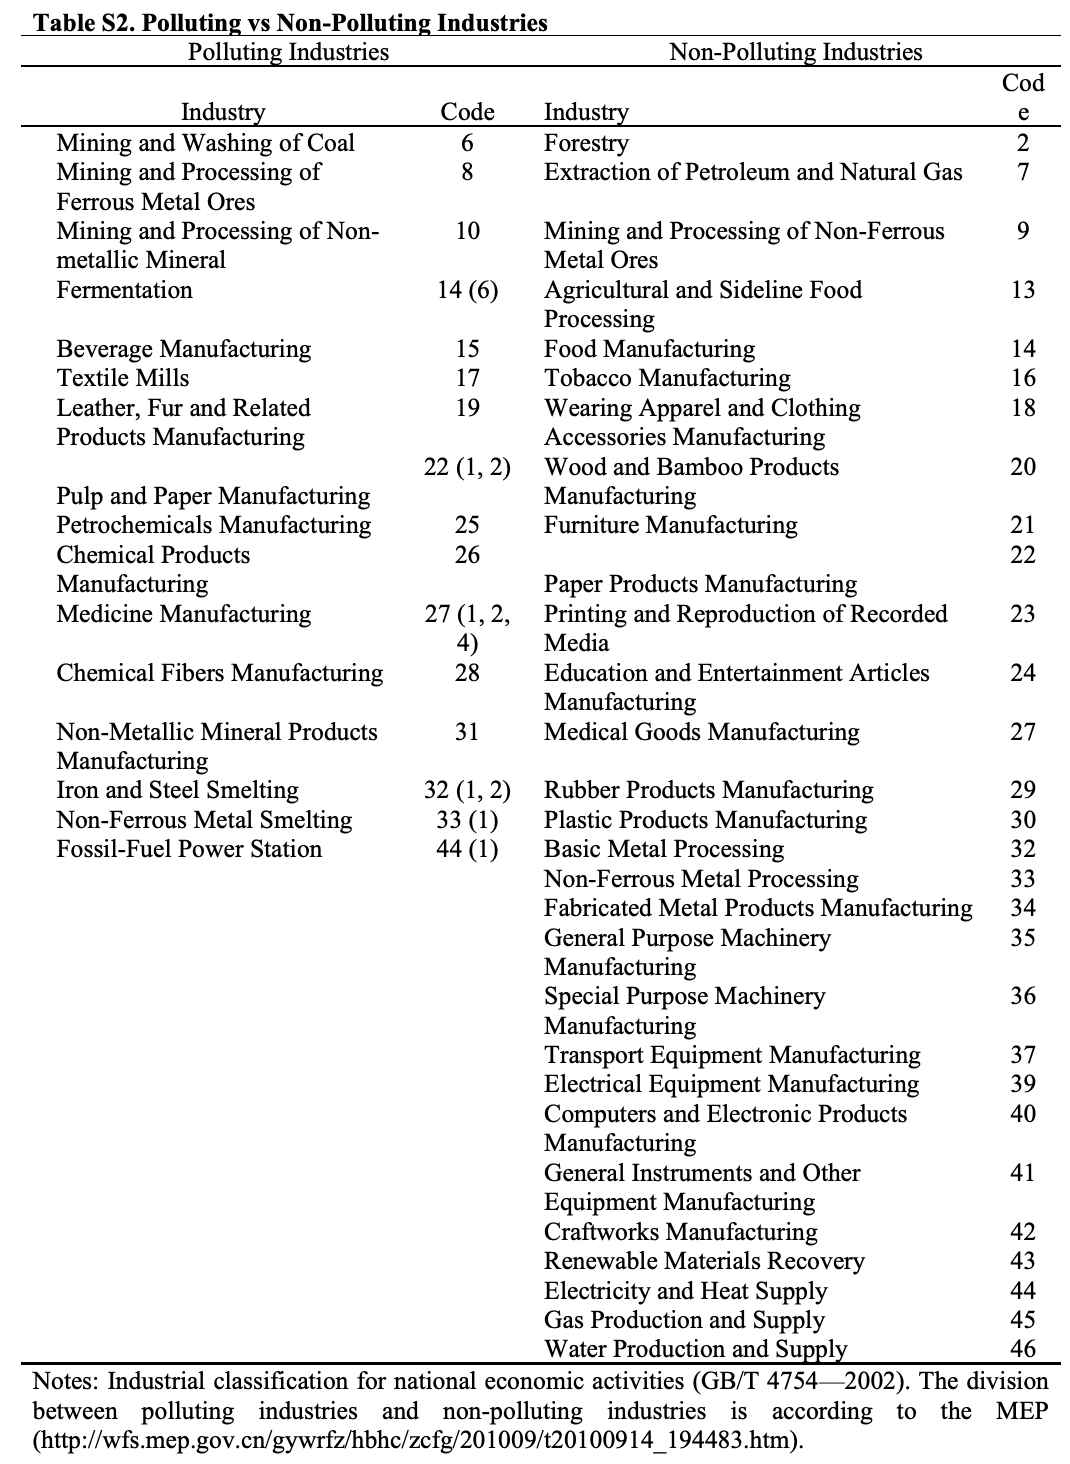

In [ ]:
list_polluting = list(
    6,8,10, 
    #14
    15, 17, 19,
    #22,
    25,26,
    #27,
    31
    #,32, 33, 44
)

In [ ]:
%get path table
###### TSO2
### CITY DOMINATED
t0 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tso2 > 300)%>%filter(ind2 %in% list_polluting)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t1 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tso2 > 300)%>%filter(!ind2 %in% list_polluting)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t2 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tso2 > 300)%>%filter(ind2 %in% list_polluting)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t3 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tso2 > 300)%>%filter(!ind2 %in% list_polluting)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

###### TCOD
t4 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tcod > 100)%>%filter(ind2 %in% list_polluting)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t5 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tcod > 100)%>%filter(!ind2 %in% list_polluting)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t6 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tcod > 100)%>%filter(ind2 %in% list_polluting)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t7 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tcod > 100)%>%filter(!ind2 %in% list_polluting)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

###### TWASTE WATER
t8 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(twaste_water > 100)%>%filter(ind2 %in% list_polluting)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t9 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(twaste_water > 100)%>%filter(!ind2 %in% list_polluting)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t10 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(twaste_water > 100)%>%filter(ind2 %in% list_polluting)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t11 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(twaste_water > 100)%>%filter(!ind2 %in% list_polluting)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

In [ ]:
etable(t0,t1, t2,t3, t4,t5,t6,t7, t8,t9, t10,t11,
         #vcov = "iid",
       headers = c("1", "2", "3", "4", "5", "6"),
       tex = TRUE,
       digits = 3,
      digits.stats = 3
)

## Table 2: heterogeneous effect: SOE vs Private

City ownership are available for the following variables:

- output
- capital
- employment
- sales

**How is it constructed**

- city ownership public vs private
    - Aggregate output by ownership and city
    - A given city will have SOE asset tangibility and PRIVATE asset tangibility [output, employment, capital and sales]
    - If asset tangibility SOE above Private then city is dominated by SOE

Notebook reference: 

https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/02_data_analysis/01_model_estimation/00_estimate_fin_ratio/03_so2_fin_ratio_sector.md#table-3-heterogeneity-effect-city-ownership-public-vs-private-domestic-vs-foreign

In [ ]:
query = """
WITH test AS (
  SELECT 
    *,
    CASE WHEN LENGTH(cic) = 4 THEN substr(cic, 1, 2) ELSE concat(
      '0', 
      substr(cic, 1, 1)
    ) END AS indu_2,
    CASE WHEN ownership = 'SOE' THEN 'SOE' ELSE 'PRIVATE' END AS soe_vs_pri,
    CASE WHEN ownership in ('HTM', 'FOREIGN') THEN 'FOREIGN' ELSE 'DOMESTIC' END AS for_vs_dom 
  FROM 
    firms_survey.asif_firms_prepared 
    INNER JOIN (
      SELECT 
        extra_code, 
        geocode4_corr 
      FROM 
        chinese_lookup.china_city_code_normalised 
      GROUP BY 
        extra_code, 
        geocode4_corr
    ) as no_dup_citycode ON asif_firms_prepared.citycode = no_dup_citycode.extra_code
  
) 
SELECT year, soe, geocode4_corr,SUM(output) as output, SUM(employ) as employ, SUM(captal) as capital
FROM (
SELECT *,
CASE WHEN ownership in ('SOE') THEN 'SOE' ELSE 'PRIVATE' END AS soe
FROM test 
  )
  GROUP BY soe, geocode4_corr, year
"""
df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename="test",  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
     )

In [ ]:
import janitor

In [ ]:
for v in ['output','employ', 'capital']:
    for t in [.5, .4, .3, .2, .1]:
        df_ = (
            df
            .set_index(['year',
                        #'indu_2',
                        'soe', 
                        'geocode4_corr'])
            .unstack(-2)
            .assign(
                soe_dominated = lambda x: x[(v, 'SOE')] > x[(v, 'PRIVATE')],
                share_soe = lambda x: x[(v, 'SOE')] / (x[(v, 'SOE')] + x[(v, 'PRIVATE')])
            )
            #.loc[lambda x: x['soe_dominated'].isin([True])]
            .collapse_levels("_")
            .reset_index()
            [['year','geocode4_corr', 
              #'indu_2',
              "soe_dominated", 
             'share_soe'
             ]]
            .loc[lambda x: x['year'].isin(["2000"])]
            .drop(columns = ['year'])
            #.rename(columns = {'indu_2':'ind2'})
            .loc[lambda x: x['share_soe']> t]
            .to_csv('list_city_soe_{}_{}.csv'.format(v, t), index = False)
        )

In [ ]:
query = """
WITH test AS (
  SELECT 
    *,
    CASE WHEN LENGTH(cic) = 4 THEN substr(cic, 1, 2) ELSE concat(
      '0', 
      substr(cic, 1, 1)
    ) END AS indu_2,
    CASE WHEN ownership = 'SOE' THEN 'SOE' ELSE 'PRIVATE' END AS soe_vs_pri,
    CASE WHEN ownership in ('HTM', 'FOREIGN') THEN 'FOREIGN' ELSE 'DOMESTIC' END AS for_vs_dom 
  FROM 
    firms_survey.asif_firms_prepared 
    INNER JOIN (
      SELECT 
        extra_code, 
        geocode4_corr 
      FROM 
        chinese_lookup.china_city_code_normalised 
      GROUP BY 
        extra_code, 
        geocode4_corr
    ) as no_dup_citycode ON asif_firms_prepared.citycode = no_dup_citycode.extra_code
  
) 
SELECT year, foreign, geocode4_corr,SUM(output) as output, SUM(employ) as employ, SUM(captal) as capital
FROM (
SELECT *,
CASE WHEN ownership in ('HTM', 'FOREIGN') THEN 'FOREIGN' ELSE 'DOMESTIC' END AS foreign
FROM test 
  )
  GROUP BY foreign, geocode4_corr, year

"""
df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename="test",  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
     )

In [ ]:
for v in ['output','employ', 'capital']:
    for t in [.5, .4, .3, .2, .1]:
        (
            df
            .set_index(['year',
                        #'indu_2',
                        'foreign', 'geocode4_corr'])
            .unstack(-2)
            .assign(
                for_dominated = lambda x: x[(v, 'FOREIGN')] > x[(v, 'DOMESTIC')],
                share_for = lambda x: x[(v, 'FOREIGN')] / (x[(v, 'FOREIGN')] + x[(v, 'DOMESTIC')])
            )
            .collapse_levels("_")
            .reset_index()
            [['year','geocode4_corr', 
              #'indu_2',
              "for_dominated", 
             'share_for'
             ]]
            .loc[lambda x: x['year'].isin(["2000"])]
            .drop(columns = ['year'])
            #.rename(columns = {'indu_2':'ind2'})
            .loc[lambda x: x['share_for']> t]
            #.groupby(['soe_dominated'])
            #.agg({'share_soe':'describe'})
            .to_csv('list_city_for_{}_{}.csv'.format(v, t), index = False)
        )

### SO2

In [ ]:
folder = 'Tables_1'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table
df_soe <- df_final %>% inner_join(read_csv('list_city_soe_output_0.5.csv'))
df_priv <- df_final %>% left_join(read_csv('list_city_soe_output_0.5.csv'))
df_dom <- df_final %>% left_join(read_csv('list_city_for_output_0.5.csv')) %>% filter(is.na(share_for))
print(dim(df_soe)[1] + dim(df_priv)[1] == dim(df_final)[1])

###### TSO2
### CITY DOMINATED
t0 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_soe %>%filter(tso2 > 300)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t1 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_priv %>%filter(tso2 > 300)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t2 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_soe %>% filter(tso2 > 300)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t3 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_priv %>% filter(tso2 > 300)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

###### TCOD
t4 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_soe %>%filter(tcod > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t5 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_priv %>%filter(tcod > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t6 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_soe %>% filter(tcod > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t7 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_priv %>% filter(tcod > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

###### TWASTE WATER
t8 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_soe %>%filter(twaste_water > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t9 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_priv %>%filter(twaste_water > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t10 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_soe %>% filter(twaste_water > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t11 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_priv %>% filter(twaste_water > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

In [ ]:
etable(t0,t1, t2,t3, t4,t5,t6,t7, t8, t9, t10, t11,
         #vcov = "iid",
       headers = c("1", "2", "3", "4", "5", "6"),
       tex = TRUE,
       digits = 3,
      digits.stats = 3
      )

## Table 3: heterogeneous effect: Domestic vs Foreign

### SO2

In [ ]:
folder = 'Tables_1'
table_nb = 3
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table
df_for <- df_final %>% inner_join(read_csv('list_city_for_output_0.5.csv'))
df_dom <- df_final %>% left_join(read_csv('list_city_for_output_0.5.csv')) %>% filter(is.na(share_for))
###### TSO2
### CITY DOMINATED
t0 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_for %>%filter(tso2 > 300)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t1 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_dom %>%filter(tso2 > 300)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t2 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_for %>% filter(tso2 > 300)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t3 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_dom %>% filter(tso2 > 300)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

###### TCOD
t4 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_for %>%filter(tcod > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t5 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_dom %>%filter(tcod > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t6 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_for %>% filter(tcod > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t7 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_dom %>% filter(tcod > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

###### TWASTE WATER
t8 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_for %>%filter(twaste_water > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t9 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_dom %>%filter(twaste_water > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t10 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_for %>% filter(twaste_water > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t11 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +  
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_dom %>% filter(twaste_water > 100)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

In [ ]:
t1

In [ ]:
etable(t0,t1, t2,t3, t4,t5,t6,t7, t8, t9, t10, t11,
         #vcov = "iid",
       headers = c("1", "2", "3", "4", "5", "6"),
       tex = TRUE,
       digits = 3,
      digits.stats = 3
      )

## Table 5: TCZ & SPZ policy

In [ ]:
folder = 'Tables_0'
table_nb = 4
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
#for ext in ['.txt', '.tex', '.pdf']:
#    x = [a for a in os.listdir(folder) if a.endswith(ext)]
#    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table
### TCZ & SPZ
###### TSO2

###### TSO2
### CITY DOMINATED
t0 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tso2 > 300& tcz == 0)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t1 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tso2 > 300& tcz == 1)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t2 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(tso2 > 300& tcz == 0)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t3 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(tso2 > 300& tcz == 1)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

###### TCOD
t4 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tcod > 100& tcz == 0)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t5 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tcod > 100& tcz == 1)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t6 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(tcod > 100& tcz == 0)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t7 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(tcod > 100& tcz == 1)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

###### TWASTE WATER
t8 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(twaste_water > 100& tcz == 0)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t9 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(twaste_water > 100& tcz == 1)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t10 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(twaste_water > 100& tcz == 0)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t11 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(twaste_water > 100& tcz == 1)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

In [ ]:
etable(t0,t1, t2,t3, t4,t5,t6,t7, t8, t9, t10, t11,
         #vcov = "iid",
       headers = c("1", "2", "3", "4", "5", "6"),
       tex = TRUE,
       digits = 3,
      digits.stats = 3
      )

In [ ]:
folder = 'Tables_0'
table_nb = 5
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
#for ext in ['.txt', '.tex', '.pdf']:
#    x = [a for a in os.listdir(folder) if a.endswith(ext)]
#    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table
### TCZ & SPZ
###### TSO2
### CITY DOMINATED
t0 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tso2 > 300& spz == 0)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t1 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tso2 > 300& spz == 1)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t2 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(tso2 > 300& spz == 0)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

t3 <- feols(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(tso2 > 300& spz == 1)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

###### TCOD
t4 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tcod > 100& spz == 0)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t5 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(tcod > 100& spz == 1)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t6 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(tcod > 100& spz == 0)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t7 <- feols(log(tcod) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(tcod > 100& spz == 1)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

###### TWASTE WATER
t8 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(twaste_water > 100& spz == 0)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t9 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            #intensity + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_concentration_sob_ct) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>%filter(twaste_water > 100& spz == 1)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t10 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint + 
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(twaste_water > 100& spz == 0)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )
t11 <- feols(log(twaste_water) ~  
            log(output) + log(employment) + log(capital) + 
            log(gdp_pop) * credit_constraint +
            log(fdi_gdp) * credit_constraint +
            log(lag_credit_supply_long_term) * credit_constraint +
            log(lag_totalBranchCity) * credit_constraint
           | fe_t_i + fe_c_t + fe_c_i,
      df_final %>% filter(twaste_water > 100& spz == 1)
      ,
      #cluster = ~geocode4_corr + ind2#
      vcov = 'iid'
              )

In [ ]:
etable(t0,t1, t2,t3, t4,t5,t6,t7, t8, t9, t10, t11,
         #vcov = "iid",
       headers = c("1", "2", "3", "4", "5", "6"),
       tex = TRUE,
       digits = 3,
      digits.stats = 3
      )

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp
import sys
path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc
import create_report

In [ ]:
name_json = 'parameters_ETL_pollution_credit_constraint.json'
path_json = os.path.join(str(Path(path).parent.parent), 'utils',name_json)
notebookname = "00_credit_supply.ipynb"

In [ ]:
create_report.create_report(extension = "html", keep_code = False, notebookname =  notebookname)

In [ ]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          #os.path.join(str(Path(path).parent), "00_download_data_from"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)